# Hydrogel-Cell Interaction

In this case, we only have the deformed shape of the spherical hydrogel as shown in the next few cells.

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as spm
from scipy.io import loadmat, savemat

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import sys, time, os.path
from itertools import permutations
sys.path.append('../module/')
from SHUtil import SphCoord_to_CartCoord, CartCoord_to_SphCoord

In [2]:
import pyshtools
from SHUtil import SHCilmToVector, SHVectorToCilm, lmk2K, K2lmk
from SHUtil import plotfv, TransMat, l_coeffs, m_coeffs
from ShElastic import calSmode, calUmode
from SHBV import generate_submat, visualize_Cmat, print_SH_mode

mu0 = 300/3;
mu = 1.; nu = 0.499;
lJmax = 20; lKmax = 20; lmax_plot = 80; lmax_work = 16; lmax_buf = lJmax-lmax_work;

shtype = 'reg'
coeff_dir = 'lmax%dmodes'%60
Umodes = loadmat(coeff_dir + '/Umodes.mat')
Umodes = (Umodes['U1'+shtype], Umodes['U0'+shtype])
fullDmat = calUmode(Umodes, mu, nu)
Dmat = generate_submat(mu, nu, fullDmat, lKmax, lJmax, kJ=3).tocsc()

Tmodes = loadmat(coeff_dir + '/Tmodes.mat')
Tmodes = (Tmodes['T1'+shtype], Tmodes['T2'+shtype], Tmodes['T3'+shtype], Tmodes['T0'+shtype])
fullCmat = calSmode(Tmodes, mu, nu)
Cmat = generate_submat(mu, nu, fullCmat, lKmax, lJmax, kJ=3).tocsc()

In [3]:
from scipy.sparse.linalg import lsqr, spsolve

# procedures for transformation between Uvec and Tvec
def Uvec2Tvec(Uvec, Cmat, Dmat, disp=False):
    tic = time.time()
    #B = lsqr(Dmat, Uvec.T)
    B_sol = spsolve(Dmat, Uvec.T)
    toc = time.time()
    #B_sol = B[0]
    #print('Residual:', B[3], 'Time:', toc-tic, 'Solution:', B_sol.size)
    print('Time: %.4fs'%(toc-tic))
    if disp:
        disp_index_sol = print_SH_mode(B_sol, m_dir=3, etol=1e-8)
    return Cmat.dot(B_sol)

def Tvec2Uvec(Tvec, Cmat, Dmat, disp=False):
    tic = time.time()
    A = lsqr(Cmat, Tvec.T, atol=0, btol=0, conlim=0)
    #A_sol = spsolve(Cmat, Tvec.T)
    toc = time.time()
    A_sol = A[0]
    print('Residual:', A[3], 'Time:', toc-tic, 'Solution:', A_sol.size)
    print('Time: %.4fs'%(toc-tic))
    if disp:
        disp_index_sol = print_SH_mode(A_sol, m_dir=3, etol=1e-8)
    return Dmat.dot(A_sol)

def SHVec2mesh(xvec, lmax=None, SphCoord=True, Complex=False):
    if lmax is None:
        lmax = (np.sqrt(xvec.size/3) - 1).astype(np.int)
    cvec = xvec.reshape(3, -1)
    nvec = cvec.shape[1]
    xmesh= [None for _ in range(3)]
    for k in range(3):
        if Complex:
            cext = np.zeros((lmax+1)**2, dtype=np.complex)
            cext[:nvec] = cvec[k, :(lmax+1)**2]
            cilm = SHVectorToCilm(cext)
        else:
            cext = np.zeros((lmax+1)**2)
            cext[:nvec] = cvec[k, :(lmax+1)**2]
            cilm = pyshtools.shio.SHVectorToCilm(cext)
        coeffs = pyshtools.SHCoeffs.from_array(cilm)
        grid = coeffs.expand('GLQ')
        xmesh[k] = grid.to_array().real
    xmesh = np.stack(xmesh, axis=-1)
    if SphCoord:
        Q = TransMat(lJmax=lmax)
        xmesh = np.sum(Q*xmesh[...,np.newaxis,:], axis=-1)
    return xmesh

# visualizing SHvectors in 2D
def visSHVec(xvec, lmax_plot=None, cmap='viridis', show=True, 
             SphCoord=True, config_quiver=(2, 4, 'k', 1), n_vrange=None, s_vrange=None,
             lonshift=0, Complex=False, figsize=(10, 5)):
    xmesh = SHVec2mesh(xvec, lmax=lmax_plot, SphCoord=SphCoord, Complex=Complex)
    if SphCoord:
        fig = [None for _ in range(2)]
        ax = [None for _ in range(2)]
        xshear= np.linalg.norm(xmesh[...,1:], axis=-1)
        
        fig[0], ax[0] = plotfv(xmesh[...,0], show=False, cmap=cmap,vrange=n_vrange,
                               lonshift=lonshift, figsize=figsize)
        ax[0].set_title('norm')
        
        fig[1], ax[1] = plotfv(xshear, show=False, cmap='Reds', lonshift=lonshift, figsize=figsize, vrange=s_vrange)
        latsdeg, lonsdeg = pyshtools.expand.GLQGridCoord(lmax_plot)
        lons, lats = np.meshgrid(lonsdeg, latsdeg)
        xshift = np.roll(xmesh, np.round(lons.shape[1]*lonshift/360).astype(np.int), axis=1)
        st, dq, color, scale = config_quiver
        ax[1].quiver(lons[::dq,st::dq], lats[::dq,st::dq], 
                     xshift[::dq,st::dq,1], xshift[::dq,st::dq,2], 
                     color=color, scale=scale)
        ax[1].set_title('shear')
    else:
        fig = [None for _ in range(3)]
        ax = [None for _ in range(3)]
        titlestr = ('x', 'y', 'z')
        for k in range(3):
            fig[k], ax[k] = plotfv(xmesh[...,k], show=False, cmap=cmap, lonshift=lonshift, figsize=figsize)
            ax[k].set_title('$'+titlestr[k]+'$')
    if show:
        plt.show()
    return fig, ax

# visualizing SHvectors in 3D
def visSH3d(xmesh, cmesh=None, r0=1, lmax_plot=None,
            figsize=(16,16), show=True, filename=None,
            elevation=0, azimuth=0, surface=False, color=None):
    if lmax_plot is None:
        lmax_plot = xmesh.shape[0] - 1
    lats, lons = pyshtools.expand.GLQGridCoord(lmax_plot)
    nlat = lats.size; nlon = lons.size;

    lats_circular = np.hstack(([90.], lats, [-90.]))
    lons_circular = np.append(lons, [lons[0]])
    u = np.radians(lons_circular)
    v = np.radians(90. - lats_circular)
    normvec = np.zeros((nlat+2, nlon+1, 3))
    normvec[...,0] = np.sin(v)[:, None] * np.cos(u)[None, :]
    normvec[...,1] = np.sin(v)[:, None] * np.sin(u)[None, :]
    normvec[...,2] = np.cos(v)[:, None] * np.ones_like(lons_circular)[None, :]

    upoints = np.zeros((nlat + 2, nlon + 1, 3))
    upoints[1:-1, :-1, :] = xmesh
    upoints[0, :, :] = np.mean(xmesh[0,:,:], axis=0)  # not exact !
    upoints[-1, :, :] = np.mean(xmesh[-1,:,:], axis=0)  # not exact !
    upoints[1:-1, -1, :] = xmesh[:, 0, :]
    upoints *= r0
    
    x = r0 * np.sin(v)[:, None] * np.cos(u)[None, :]  + upoints[..., 0]
    y = r0 * np.sin(v)[:, None] * np.sin(u)[None, :] + upoints[..., 1]
    z = r0 * np.cos(v)[:, None] * np.ones_like(lons_circular)[None, :] + upoints[...,2]

    if color is None:
        if cmesh is None:
            magn_point = np.sum(normvec * upoints, axis=-1)
        else:
            tpoints = np.zeros((nlat + 2, nlon + 1, 3))
            tpoints[1:-1, :-1, :] = cmesh
            tpoints[0, :, :] = np.mean(cmesh[0,:,:], axis=0)  # not exact !
            tpoints[-1, :, :] = np.mean(cmesh[-1,:,:], axis=0)  # not exact !
            tpoints[1:-1, -1, :] = cmesh[:, 0, :]
            magn_point = np.sum(normvec * tpoints, axis=-1)
        magn_face = 1./4. * (magn_point[1:, 1:] + magn_point[:-1, 1:] +
                             magn_point[1:, :-1] + magn_point[:-1, :-1])
        magnmax_face = np.max(np.abs(magn_face))
        magnmax_point = np.max(np.abs(magn_point))
        norm = plt.Normalize(-magnmax_face / 2., magnmax_face / 2., clip=True)
        cmap = plt.get_cmap('RdBu_r')
        colors = cmap(norm(magn_face.flatten()))
        colors = colors.reshape(nlat + 1, nlon, 4)

    fig = plt.figure(figsize=figsize)
    ax3d = fig.add_subplot(1, 1, 1, projection='3d')
    if surface:
        if color is None:
            ax3d.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=colors)
        else:
            ax3d.plot_surface(x, y, z, rstride=1, cstride=1, color=color)
    else:
        ax3d.scatter(x, y, z)
    ax3d.view_init(elev=elevation, azim=azimuth)
    ax3d.tick_params(labelsize=16)

    if filename is not None:
        plt.tight_layout()
        fig.savefig(filename,transparent=True)
    if show:
        plt.show(block=True)
    return fig, ax3d

# convert between complex and real SH vectors

def SHvec_rtoc(xvec):
    rcilm = pyshtools.shio.SHVectorToCilm(xvec)
    ccilm = pyshtools.shio.SHrtoc(rcilm)
    cilm = np.zeros_like(ccilm, dtype=np.complex)
    cilm[0,...] = ccilm[0,...] + 1.j*ccilm[1,...]
    cilm[1,:,1:] = (-1)**m_coeffs(lJmax)[0,:,1:] * cilm[0,:,1:].conj()
    return SHCilmToVector(cilm)

def SHvec_ctor(xvec):
    cilm = SHVectorToCilm(xvec)
    ccilm = np.zeros_like(cilm, dtype=np.float)
    ccilm[0,...] = cilm[0,...].real
    ccilm[1,...] = cilm[0,...].imag
    rcilm = pyshtools.shio.SHctor(ccilm)
    return pyshtools.shio.SHCilmToVector(rcilm)

In [4]:
#### load the geometry ####
# Vs, Vp: list of nodes (nV, trivial), coordinates of the nodes (nVx3)
# Es, Ep: list of edges (nEx2), list of points on the edges (nEx2x3)
# Fs, Fp: list of facets (nFx3), list of points on the facets (nFx3x3)
# Tfv: traction free boundary map of the node list
# Tfe: traction free boundary map of the edge list
# Tff: traction free boundary map of the face list
# Tf_diluted: diluted traction free boundary map

#data = np.genfromtxt('../testdata/Coordinates_irregular_boundary.csv', delimiter=',')
#conn = np.genfromtxt('../testdata/Connectivity.csv', delimiter=',', dtype=np.int)
smoothed = 'smoothed'; smoothed = '';
dilated = '_1um_dilated';# dilated = '';
shapename = 'Shape2'
data = np.genfromtxt('../testdata/'+shapename+'_Coordinates_Cart_'+smoothed+'.csv', delimiter=',')
conn = np.genfromtxt('../testdata/'+shapename+'_Connectivity.csv', delimiter=',', dtype=np.int)
if shapename == 'Shape4':
    mask = np.zeros_like(data[:,0]).astype(np.int)
else:
    mask = np.genfromtxt('../testdata/'+shapename+'_Mask'+dilated+'.csv', dtype=np.int)
print('data, connectivity:', data.shape, conn.shape)

Fs = conn - 1
Np = data.shape[0]
Vs = np.arange(Np)
edge_conn = spm.lil_matrix((Np, Np), dtype=bool)
for i, j in permutations(range(3), 2):
    edge_conn[Fs[:, i], Fs[:, j]] = True
Es = spm.triu(edge_conn).tocoo()
Es = np.vstack([Es.row, Es.col]).T
print('id of nodes, edges, facets:', Vs.shape, Es.shape, Fs.shape)
Vp = data[..., :3]
#print(data[:,2].mean(), data[:,1].max(), data[:,0].max())
#Vp[:,0],Vp[:,1],Vp[:,2] = SphCoord_to_CartCoord(data[:,2],data[:,1],data[:,0])
Ep = Vp[Es, :]; Fp = Vp[Fs, :];
print('coord of nodes, edges, facets:', Vp.shape, Ep.shape, Fp.shape)

#Tf_diluted = data[:, 4].astype(np.bool)
#Tfv = np.logical_not(data[:, 3].astype(np.bool))
Tfv = mask.astype(np.bool) # np.logical_not(mask.astype(np.bool))
Tfe = np.all(Tfv[Es], axis=1)
Tff = np.all(Tfv[Fs], axis=1)
print('Traction free boundary of v, e, f:', Tfv.shape, Tfe.shape, Tff.shape)

data, connectivity: (8136, 3) (16268, 3)
id of nodes, edges, facets: (8136,) (24402, 2) (16268, 3)
coord of nodes, edges, facets: (8136, 3) (24402, 2, 3) (16268, 3, 3)
Traction free boundary of v, e, f: (8136,) (24402,) (16268,)


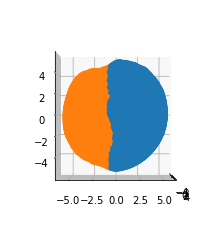

In [5]:
#### Plot the geometry (Vp) ####

fig = plt.figure()#figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')

nTfv = np.logical_not(Tfv)
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], 'C0')
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], 'C1')

eTf = Line3DCollection(np.hstack([Ep[Tfe, 0, :], Ep[Tfe, 1, :]]).copy().reshape((-1,2,3)), colors='C0')
ax.add_collection(eTf)
nTfe = np.logical_not(Tfe)
eTf = Line3DCollection(np.hstack([Ep[nTfe, 0, :], Ep[nTfe, 1, :]]).copy().reshape((-1,2,3)), colors='C1')
ax.add_collection(eTf)

ax.view_init(azim=0, elev=0)

ax.set_aspect('equal')
plt.show()

Then we determine the original radius of the particle, assuming the particle is incompressible. The total volume can be estimated by adding the volume of the tetrahedrons. The volume of a tetrahedron is calculated as:

$$
V_{0123}=\frac{1}{6}
\begin{vmatrix}
 x_1 & y_1 & z_1 & 1\\ 
 x_2 & y_2 & z_2 & 1\\ 
 x_3 & y_3 & z_3 & 1\\ 
 0 & 0 & 0 & 1\\ 
\end{vmatrix}
$$

In [6]:
tet = np.zeros((Fs.shape[0], 4, 4))
tet[:,:-1,:-1] = Fp
tet[:,:,-1] = 1
vol = np.sum(np.linalg.det(tet)/6, axis=0)
r0 = np.cbrt(vol/(4/3*np.pi))
print('V = %.4f, r0 = %.4f'%(vol, r0))

V = 607.3097, r0 = 5.2534


We need to solve the reverse problem of a deformed shape. We will try the following methods to tackle this problem:

1. Assume $r$-direction deformation only
2. LSQ solving spherical harmonic coefficients for the displacement field
3. LSQ solving coeffs of the SH solutions for fitting both the traction-free boundary and the shape

## 1. Assume $r$-direction deformation only

First thing to try is assuming that the deformation only happens on $r$-direction.

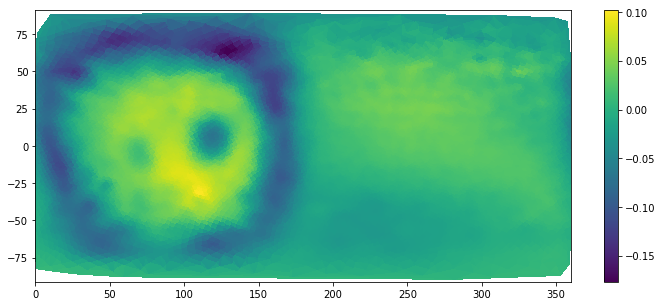

In [7]:
# Vp -> ur (radial displacement) -> u1 (x,y,z)
Vr = np.linalg.norm(Vp, axis=1)
Vthe = np.arccos(Vp[:,2]/Vr)
Vphi = np.arctan2(Vp[:,1], Vp[:,0])
Vphi[Vphi < 0] += 2*np.pi
Vlat = 90-np.rad2deg(Vthe)
Vlon = np.rad2deg(Vphi)

ur = (Vr - r0)/r0

# plot 2d map of the radial displacement
pVlon = Vlon - 180
pVlon[pVlon < 0] += 360
plt.figure(figsize=(12,5))
plt.tripcolor(pVlon, Vlat, ur)
plt.colorbar()
plt.axis('equal')
plt.xlim(0, 360)
plt.ylim(-90, 90)
plt.show()

# displacement on the unit sphere
#u1 = -(r0/Vr[:,np.newaxis]-1)*Vp/r0 #(Vr/r0-1)[...,np.newaxis]*Vp
u1 = ur[:,np.newaxis] * (Vp/Vr[:,np.newaxis])

# NOTE: All the displacements are normalized with $r_0$, and tractions are normalized with $\mu_0$

The following block shows an incorrect approach where the displacements are fitted separately in each Cartesian elements, which will introduce shear displacement later.

Instead, we expand $u_r$ and obtain regular grid representation, then obtain $u_x,u_y,u_z$ from regular $u_r$ ($u_\theta=u_\varphi=0$).

0.11092364380079114
kind = 'real'
normalization = '4pi'
csphase = 1
lmax = 20


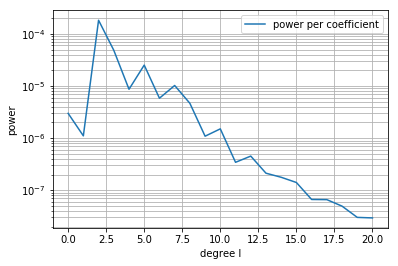

In [8]:
urcilm, chi2 = pyshtools.expand.SHExpandLSQ(ur, Vlat, Vlon, lmax=lJmax)
print(chi2)
urcoeffs = pyshtools.SHCoeffs.from_array(urcilm)
urcoeffs.info()
spec_before = urcoeffs.spectrum(unit='per_lm')
fig,ax=urcoeffs.plot_spectrum(unit='per_lm')

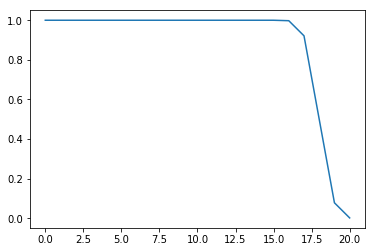

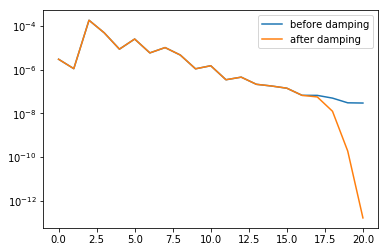

In [9]:
from scipy.special import erfc
# damp the high order coefficients
lmax_mean = lmax_work + np.int(lmax_buf/2);
ldamp = erfc((l_coeffs(lJmax) - lmax_mean)/(lmax_buf/4))/2

urcoeffs = pyshtools.SHCoeffs.from_array(urcilm*ldamp)
spec_after = urcoeffs.spectrum(unit='per_lm')

#fig,ax=urcoeffs.plot_spectrum(unit='per_lm')
plt.plot(ldamp[0,:,0])
plt.show()

plt.semilogy(spec_before); plt.semilogy(spec_after);
plt.legend(['before damping', 'after damping'])
plt.show()
#print(ldamp.shape)

kind = 'real'
grid = 'GLQ'
nlat = 81
nlon = 161
lmax = 80


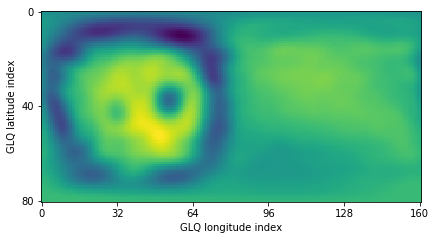

In [10]:
urgrid = urcoeffs.pad(lmax=lmax_plot).expand('GLQ')
urgrid.info()
urgrid.data = np.roll(urgrid.data, lmax_plot+1, axis=1)
fig, ax = urgrid.plot()
urgrid.data = np.roll(urgrid.data, -lmax_plot-1, axis=1)

In [11]:
# Convert Back to ux,uy,uz on regular mesh

Q = TransMat(lJmax=lmax_plot)
print(Q.shape)
u1a = urgrid.data[:,:,np.newaxis]*Q[:,:,0,:]
print(u1a.shape)

(81, 161, 3, 3)
(81, 161, 3)


Displacement in Spherical Coordinates...


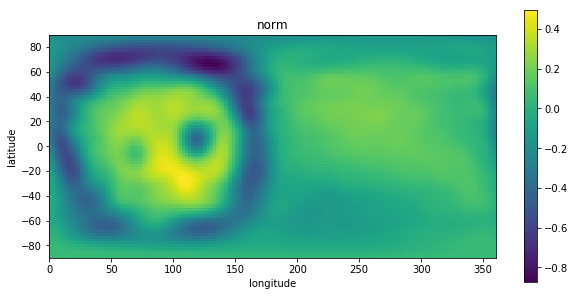

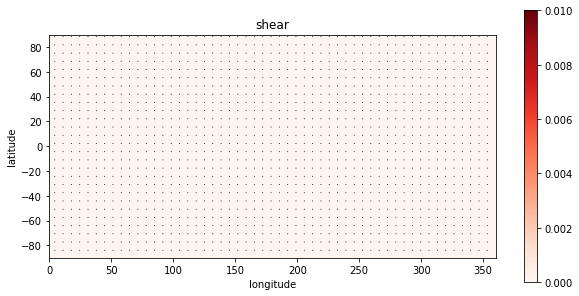

Displacement SH Coefficients...U1avec0


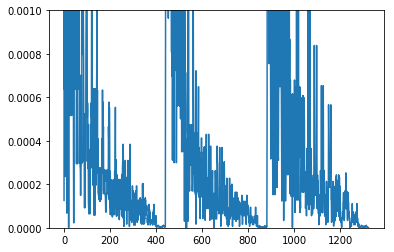

solution coefficients...AK


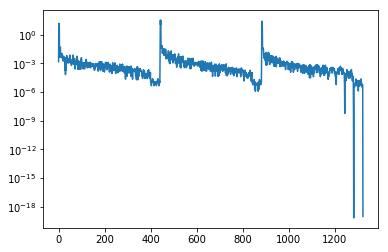

In [12]:
# Construct initial guess AK
# decompose the displacement field into spherical harmonic coefficients
U1avec0 = [None for _ in range(3)]
for k in range(3):
    u1agrid = pyshtools.SHGrid.from_array(u1a[...,k].astype(np.complex), grid='GLQ')
    u1acoeffs = u1agrid.expand().pad(lmax=lJmax)
    U1avec0[k] = SHCilmToVector(u1acoeffs.to_array())
U1avec0 = np.hstack(U1avec0)

print('Displacement in Spherical Coordinates...')
fig, ax = visSHVec(U1avec0*r0, lmax_plot=80, SphCoord=True, Complex=True, s_vrange=(0,0.01),
                       config_quiver=(2, 3, 'k', 0.2), lonshift=180)
print('Displacement SH Coefficients...U1avec0')
plt.plot(np.abs(U1avec0))
plt.ylim(0,0.001)
plt.show()

from scipy.sparse.linalg import spsolve, cgs
AK_init = spsolve(Dmat.tocsc(), U1avec0.T);

print('solution coefficients...AK')
plt.semilogy(np.abs(AK_init)); plt.show();

## 2. LSQ solving SH coeffs for displacement field

Obviously, the decomposition is not satisfactory. It is not reasonable to assume the deformation is only on $r$-direction. In this section, we will try to optimize SH coeffs, so that the deformed shape is closest to the data. Notice that the integral of a spherical harmonic function on the sphere surface is:

$$
\int_0^{2\pi}\!\int_0^{\pi}Y_l^m(\theta,\varphi)\sin\theta d\theta d\varphi = 4\pi\delta_{l0}\delta_{m0}
$$

Therefore, only the $Y_0^0$ term controls the rigid body translation (constant). If we only impose higher mode spherical harmonics, there will be no rigid body motion. But here we will impose the coefficient for $Y_0^0$ to obtain the rigid body motion.

### 2.1 Developing distance function and neighbor list

We first develop the distance function of the point sets to the surface. The distance of a point $x$ to the surface is defined as: $d(x) = \min[d_{v}(x), d_{e}(x), d_{f}(x)]$, where $d_v(x)$, $d_e(x)$, $d_f(x)$ are the closest distances of $x$ to the vertices, edges, and faces respectively.

* For a vertex $v=(v_1,v_2,v_3)^T$, $d_v(x)=\|\mathbf{x-v}\|_2$. The test script is attached.

In [13]:
def d2v(Xs, Xv, avg_dist=True, vert_weight=1):
    #### point-to-point distance
    ## Xs: points for testing (..., 3); 
    ## Xv: m data points (m, 3);
    ## avg_dist: if True, calculate the average shape difference per node
    ## vert_weight: the weighing function for different coordinates (3, )
    d2vmat = np.linalg.norm((Xs[..., np.newaxis, :]-Xv)*vert_weight, axis=-1)   # pair-wise distances (..., m)
    if avg_dist:
        return d2vmat.min(axis=-1).mean()
    else:
        return d2vmat

* For an edge $e=(r_1, r_2)$, the projection point $\vec{r_1q}$ on $\vec{r_1r_2}$ is 
$$
\vec{r_1q} = \frac{\vec{r_1x}\cdot\vec{r_1r_2}}{\|\vec{r_1r_2}\|}\,\frac{\vec{r_1r_2}}{\|\vec{r_1r_2}\|}
$$

The projection is in the interval $r_1r_2$ if $t=\|\vec{r_1q}\|/\|\vec{r_1r_2}\|\in(0,1)$. 
Thus, the distance to the edge is calculated as:
$$
d_e(x)=
\begin{cases}
\|\vec{r_1x}\|,\; t\le0 \\
\|\vec{qx}\|,\; 0<t\le1 \\
\|\vec{r_2x}\|,\; t>1 
\end{cases}
$$
A test case is attached here.

In [14]:
def d2e(Xs, Xe, e_cached=None, avg_dist=True, infval=False, debug=False):
    #### point-to-edge distance
    ## Xs: points for testing (..., 3); 
    ## Xe: m edges from data (m, 2, 3);
    ## avg_dist: if True, calculate the average shape difference per node
    ## infval: if True, the projection outside the edge will be consider infinite distance
    ## debug: output info for debug/testing
    if e_cached is None:
        r1 = Xe[..., 0, :]; r2 = Xe[..., 1, :]; r12 = r2 - r1;        # m x 3, edge vertices
        l12 = np.linalg.norm(r12, axis=-1)                            # m,     edge length
    else:
        r1, r12, l12 = e_cached
    t = np.sum((Xs[..., np.newaxis, :]-r1)*r12, axis=-1)/l12**2   # n x m,     projection ratio
    t_cal = t.copy(); t_cal[t<0] = 0; t_cal[t>1] = 1;             # a copy of t for calculation
    q = r1 + (t_cal[...,np.newaxis]*r12)                          # n x m x 3, projection point
    d2emat = np.linalg.norm(Xs[..., np.newaxis, :] - q, axis=-1)  # n x m
    if infval:
        d2emat[np.logical_or(t<0, t>1)] = np.inf
    if avg_dist:
        return d2emat.min(axis=-1).mean()
    else:
        if debug:
            dr1 = np.linalg.norm(Xs[..., np.newaxis, :] - r1, axis=-1)
            dr2 = np.linalg.norm(Xs[..., np.newaxis, :] - r2, axis=-1)
            return (d2emat, q, dr1, dr2)
        else:
            return d2emat

* For a face $f=(r_1, r_2, r_3)$, the normal vector:
$$
n = \frac{\vec{r_1r_2}\times\vec{r_1r_3}}{\|\vec{r_1r_2}\times\vec{r_1r_3}\|}
$$
Then the distance can be calculated as:
$$
d_f(x)=\|\vec{r_1x}\cdot\vec{n}\|
$$
if the projection point $q$ is in the triangle, where $q = x - (\vec{r_1x}\cdot\vec{n})\vec{n}$.

To test this, we calculate the barycentric coordinates of $q$:
$$
b_3 = \frac{\|r_1\|^2\times(\vec{r_1r_3}\cdot\vec{r_1q})-
            (\vec{r_1r_2}\cdot\vec{r_1r_3})\times(\vec{r_1r_2}\cdot\vec{r_1q})}
           {\|r_1\|^2\|r_2\|^2-(\vec{r_1r_2}\cdot\vec{r_1r_3})^2}\\
b_2 = \frac{\|r_2\|^2\times(\vec{r_1r_2}\cdot\vec{r_1q})-
            (\vec{r_1r_2}\cdot\vec{r_1r_3})\times(\vec{r_1r_3}\cdot\vec{r_1q})}
           {\|r_1\|^2\|r_2\|^2-(\vec{r_1r_2}\cdot\vec{r_1r_3})^2}\\
b_1 = 1 - b_2 - b_3
$$

If any $b_i < 0$, $q$ is outside of the triangle, we then calculate the point edge distances $d_e(x)$ instead.

In [15]:
def generate_fcache(Xf):
    r0 = Xf[..., 0, :]; r1 = Xf[..., 1, :]; r2 = Xf[..., 2, :];    # m x 3
    nf = np.cross(r1-r0, r2-r0)                                    # normal vector
    nf = nf / np.linalg.norm(nf, axis=-1)[...,np.newaxis]          # m x 3
    r11 = np.sum((r2 - r0)**2, axis=-1)                            # m
    r00 = np.sum((r1 - r0)**2, axis=-1)                            # m
    r01 = np.sum((r1-r0)*(r2-r0), axis=-1)                         # m
    d = r11*r00 - r01*r01                                          # m
    return r0, r1, r2, nf, r00, r11, r01, d

def d2f(Xs, Xf, f_cached=None, avg_dist=True, infval=False, debug=False, vert_weight=1, fasteval=False):
    #### point-to-face distance
    ## Xs: points for testing (..., 3); 
    ## Xf: m faces from data (m, 3, 3);
    ## avg_dist: if True, calculate the average shape difference per node
    ## infval: if True, the projection outside the face will be consider infinite distance
    ## debug: output info for debug/testing
    ## vert_weight: the weighing function for different coordinates (3, )
    ## fasteval: if True, only calculate the point-vertex distances for estimation.

    if fasteval:
        d2fmat = np.linalg.norm(Xs[...,np.newaxis,np.newaxis,:] - Xf, axis=-1).min(axis=-1)
    else:
        if f_cached is None:
            f_cached = generate_fcache(Xf)
        r0, r1, r2, nf, r00, r11, r01, d = f_cached
        pq = np.sum((Xs[...,np.newaxis,:]-r0)*nf*vert_weight, axis=-1)     # n x m
        q = Xs[...,np.newaxis,:] - pq[...,np.newaxis]*nf               # n x m x 3, projection point
        d2fmat = np.abs(pq)                                            # n x m

        # determine the barycentric coordinate of q
        r12  = np.sum((r2-r0)*(q-r0), axis=-1)                         # n x m
        r02  = np.sum((r1-r0)*(q-r0), axis=-1)                         # n x m
        bary = np.zeros_like(q)                                        # n x m x 3
        bary[...,2] = (r00*r12-r01*r02)/d
        bary[...,1] = (r11*r02-r01*r12)/d
        bary[...,0] = 1 - bary[...,1] - bary[...,2]
        out = np.any(bary < 0, axis=-1)                                # n x m

        # determine the closest point on the edges
        Xfv= np.broadcast_to(Xf, q.shape+(3,))[out]                    # n_out x 3 x 3
        Xp = np.broadcast_to(Xs[...,np.newaxis,:], q.shape)[out]       # n_out x 3
        ve = np.roll(Xfv, 1, axis=-2)-Xfv                              # n_out x 3 x 3
        le = np.linalg.norm(ve, axis=-1)                               # n_out x 3
        ts = np.sum(ve*(Xp[...,np.newaxis,:]-Xfv), axis=-1)/le**2      # n_out x 3
        ts[ts > 1] = 1; ts[ts < 0] = 0;
        qs = Xfv+(ts[...,np.newaxis]*ve)
        dq = np.linalg.norm(((Xp[...,np.newaxis,:]-qs)*vert_weight), axis=-1)       # n_out x 3
        d2fmat[out] = np.min(dq, axis=-1)
        if debug:
            return (d2fmat, q)
        else:
            return d2fmat

    if avg_dist:
        return d2fmat.min(axis=-1).mean()
    else:
        return d2fmat

With the distance function ready, we can develop the neighbor list by choosing the closest 70 vertices, edges and faces to the points:

In [16]:
# Shape of the initial guess U1avec0: Xt = X0 + u1a

latsdeg, lonsdeg = pyshtools.expand.GLQGridCoord(lJmax)
lon = np.deg2rad(lonsdeg)
colat = np.deg2rad(90-latsdeg)
PHI, THETA = np.meshgrid(lon, colat)
R = np.ones_like(PHI)
X,Y,Z = SphCoord_to_CartCoord(R, THETA, PHI)
X0 = np.stack([X,Y,Z], axis=-1)

Xt = X0 + SHVec2mesh(U1avec0, lmax=lJmax, SphCoord=False, Complex=True)

In [17]:
n_list = 200
file_neigh_fast = shapename+'_neigh%d_lmax%d'%(n_list, lJmax)+smoothed+dilated+'_Fneigh.npz'
if not os.path.exists(file_neigh_fast):
    d2fmat = d2f(Xt, Fp/r0, avg_dist=False, fasteval=True)
    d2farg = np.argsort(d2fmat)[...,:n_list*2]
    Fn = Fp[d2farg]/r0
    np.savez(file_neigh_fast, Fneigh=Fn)
else:
    Fn = np.load(file_neigh_fast)['Fneigh']
print('Fast facet neighbor:', Fn.shape)

file_neigh = shapename+'_neigh%d_lmax%d'%(n_list, lJmax)+smoothed+dilated+'.npz'
if not os.path.exists(file_neigh):
    print(X0.shape, Vp.shape, Ep.shape, Fn.shape, r0)
    d2vmat = d2v(Xt, Vp/r0, avg_dist=False)
    d2emat = d2e(Xt, Ep/r0, avg_dist=False)
    d2fmat = d2f(Xt, Fn, avg_dist=False)
    print(d2vmat.shape, d2emat.shape, d2fmat.shape)

    d2varg = np.argsort(d2vmat)[...,:n_list]
    d2earg = np.argsort(d2emat)[...,:n_list]
    d2farg = np.argsort(d2fmat)[...,:n_list]
    d2farg0 =np.broadcast_to(np.arange(d2farg.shape[0])[:,np.newaxis,np.newaxis], d2farg.shape)
    d2farg1 =np.broadcast_to(np.arange(d2farg.shape[1])[np.newaxis,:,np.newaxis], d2farg.shape)
    Xneigh = Vp[d2varg]/r0
    Eneigh = Ep[d2earg]/r0
    Fneigh = Fn[(d2farg0, d2farg1, d2farg)]

    np.savez(file_neigh, Xneigh=Xneigh, Eneigh=Eneigh, Fneigh=Fneigh)

n_load = 40
Xneigh = np.load(file_neigh)['Xneigh'][...,:n_load,:]
Eneigh = np.load(file_neigh)['Eneigh'][...,:n_load,:,:]
Fneigh = np.load(file_neigh)['Fneigh'][...,:n_load,:,:]
print('Neighbor list:', Xneigh.shape, Eneigh.shape, Fneigh.shape)

Fast facet neighbor: (21, 41, 400, 3, 3)
Neighbor list: (21, 41, 40, 3) (21, 41, 40, 2, 3) (21, 41, 40, 3, 3)


Visualize the neighbor list on deformed shape:

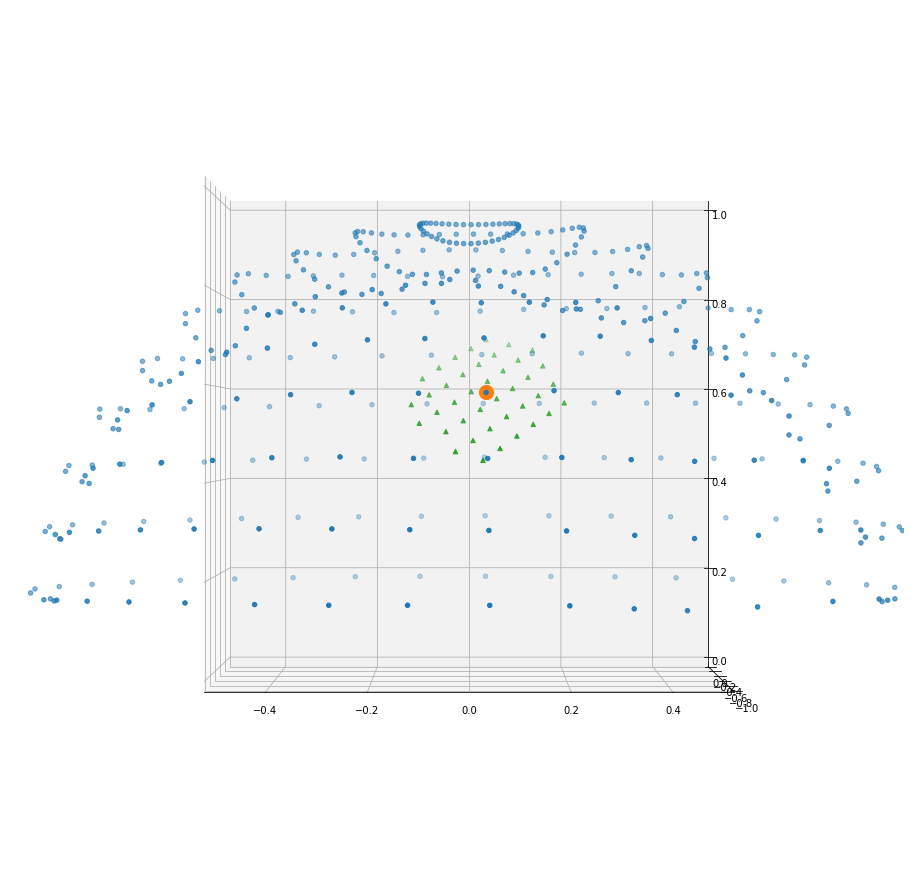

In [18]:
i = 6; j = 31; k = 10
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(Xt[0:k,:, 0], Xt[0:k,:, 1], Xt[0:k,:, 2])
#ax.scatter3D(Xt[:, :, 0], Xt[:, :, 1], Xt[:, :, 2], s=1)
ax.scatter3D(Xt[i, j, 0], Xt[i, j, 1], Xt[i, j, 2], s=200)
ax.scatter3D(Xneigh[i, j, :, 0], Xneigh[i, j, :, 1], Xneigh[i, j, :, 2], marker = '^')
#nTfv = np.logical_not(Tfv)
#ax.scatter3D(Vp[Tfv, 0]/r0, Vp[Tfv, 1]/r0, Vp[Tfv, 2]/r0, s = 1)#, c='C0')
#ax.scatter3D(Vp[nTfv, 0]/r0, Vp[nTfv, 1]/r0, Vp[nTfv, 2]/r0, s = 1)#, c='C1')
ax.view_init(azim=-90, elev=0)
ax.set_zlim3d(0, 1); ax.set_xlim3d(-0.5, 0.5); ax.set_ylim3d(-1, 0)
#ax.set_aspect('equal')

plt.show()

### 2.2  From `uvec` to the shape difference

After we obtain the neighbor list, the shape can be obtained from the real SH vector `uvec`. This can be used for the optimization of the shape.

latitude weight function shape: (21, 41) (3,) (441,)


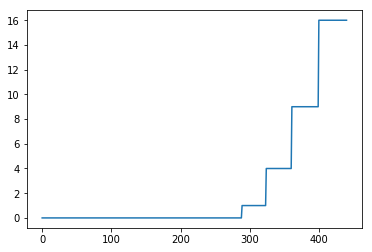

In [19]:
from SHUtil import LM_list
# err_ratio = 1/3.2
# lat_weights = (((1-err_ratio)*np.sin(colat)+err_ratio)**2).reshape(-1,1,1,1)
lat_weights = np.sin(THETA)**2
vert_weight = np.array([1,1,1./3])**2
l_list, m_list = LM_list(lJmax)
#l_weight = l_list**2;
l_weight = l_list - (lJmax - lmax_buf); l_weight[l_weight < 0] = 0; l_weight = l_weight**2;
print('latitude weight function shape:', lat_weights.shape, vert_weight.shape, l_weight.shape)
plt.plot(l_weight); plt.show()

def coeffs2dist(xvec, Xt=None, f_cached=None, lmax=None, X0=None, Complex=False, 
                lat_weights=1, vert_weight=1, l_weight=None, debug=False):
    #### shape difference from SH vectors
    ## xvec: Input real SH vector (3x(lmax+1)^2)
    ## Xt: Input shape data (nv x 3) or (nf x 3 x 3); can be full list or neighbor list
    ## f_cached: Default None, Xt is the coordinates of vertices; otherwise, Xt is the
    ##          coordinates of faces, and f_cached provides the pre-calculated values.
    ## lmax, X0: pre-calculated parameters for speed-up. Explained in the code.
    ## Complex: Default False, xvec is the real SH vector using pyshtools.shio.SHVectorToCilm;
    ##          otherwise, it will be complex SH vector using SHUtil.SHVectorToCilm;
    ## lat_weights: weighing function for different densities of nodes on different lattitudes.
    ## vert_weight: weighing function for different error in different directions
    ## l_weight: weighing function for coefficients (anti-aliasing)
    if lmax is None:
        lmax = np.sqrt(xvec.size/3).astype(np.int) - 1
    nvec = (lmax+1)**2
    cvec = xvec.reshape(3, nvec)
    # expand the displacement field onto a mesh
    umesh= [None for _ in range(3)]
    for k in range(3):
        if Complex:
            cilm = SHVectorToCilm(cvec[k, :])
        else:
            cilm = pyshtools.shio.SHVectorToCilm(cvec[k, :])
        coeffs = pyshtools.SHCoeffs.from_array(cilm)
        grid = coeffs.expand('GLQ')
        umesh[k] = grid.to_array().real
    umesh = np.stack(umesh, axis=-1)
    # calculate the shape
    if X0 is None:
        lon = np.deg2rad(grid.lons())
        colat = np.deg2rad(90-grid.lats())
        PHI, THETA = np.meshgrid(lon, colat)
        R = np.ones_like(PHI)
        X,Y,Z = SphCoord_to_CartCoord(R, THETA, PHI)
        X0 = np.stack([X,Y,Z], axis=-1)
    Xs = X0 + umesh

    if f_cached is None:
        d2surfsum = np.sum(((Xs[..., np.newaxis, :]-Xt))**2*vert_weight, axis=-1)
        d2surf = d2surfsum.min(axis=-1)
        if debug:
            return d2surfsum
    else:
        #d2surf = d2f(Xs, Xt, f_cached=f_cached, avg_dist=False, vert_weight=vert_weight).min(axis=-1)
        r0, r1, r2, nf, r00, r11, r01, d = f_cached; Xf = Xt;
        pq = np.sum((Xs[...,np.newaxis,:]-r0)*nf, axis=-1)             # n x m
        q = Xs[...,np.newaxis,:] - pq[...,np.newaxis]*nf               # n x m x 3, projection point
        d2fmat = np.sum(((Xs[...,np.newaxis,:]-r0)*nf)**2*vert_weight, axis=-1)   # n x m

        # determine the barycentric coordinate of q
        r12  = np.sum((r2-r0)*(q-r0), axis=-1)                         # n x m
        r02  = np.sum((r1-r0)*(q-r0), axis=-1)                         # n x m
        bary = np.zeros_like(q)                                        # n x m x 3
        bary[...,2] = (r00*r12-r01*r02)/d
        bary[...,1] = (r11*r02-r01*r12)/d
        bary[...,0] = 1 - bary[...,1] - bary[...,2]
        out = np.any(bary < 0, axis=-1)                                # n x m

        # determine the closest point on the edges
        Xfv= np.broadcast_to(Xf, q.shape+(3,))[out]                    # n_out x 3 x 3
        Xp = np.broadcast_to(Xs[...,np.newaxis,:], q.shape)[out]       # n_out x 3
        ve = np.roll(Xfv, 1, axis=-2)-Xfv                              # n_out x 3 x 3
        le = np.linalg.norm(ve, axis=-1)                               # n_out x 3
        ts = np.sum(ve*(Xp[...,np.newaxis,:]-Xfv), axis=-1)/le**2      # n_out x 3
        ts[ts > 1] = 1; ts[ts < 0] = 0;
        qs = Xfv+(ts[...,np.newaxis]*ve)
        dq = np.sum(((Xp[...,np.newaxis,:]-qs))**2*vert_weight, axis=-1)       # n_out x 3
        d2fmat[out] = np.min(dq, axis=-1)
        d2surf = d2fmat.min(axis=-1)
        if debug:
            return d2fmat
    
    if l_weight is None:
        regularization = 0
    else:
        regularization = np.linalg.norm(np.tile(l_weight, 3)*xvec)
    return np.mean(d2surf*lat_weights) + regularization*0.05

### 2.3 Target function including shape and traction

In [64]:
x0 = Xt;
dist2mat = np.linalg.norm(x0[..., np.newaxis, :] - Vp/r0, axis=-1)
arg_list_x = dist2mat.argmin(axis=-1)
isTfv = Tfv[arg_list_x]

Q = TransMat(lJmax=lJmax)           # transformation matrix from Cartesian to Spherical Coordinates
l_list, m_list = LM_list(lJmax)
#l_weight = l_list**2; 
ndamp = ((lJmax+1)**2 - (lJmax+1-lmax_buf)**2)*3
l_weight = l_list - (lJmax - lmax_buf); l_weight[l_weight < 0] = 0; l_weight = 100**(l_weight) - 1;
A_weight = np.tile(l_weight, 3)
print(A_weight.shape)

def sol2dist(aK, Cmat, Dmat, alpha = 0.05, separate=False, f_cached=None, lmax=None, X0=None, Xt=None,
             lat_weights=1, vert_weight=1, l_weight=None):
    #vert_weight = 1; lat_weights = 1;
    Tvec = Cmat.dot(aK)
    Uvec = Dmat.dot(aK)
    nvec = (lmax+1)**2
    tcvec = Tvec.reshape(3, -1)
    # expand the displacement and traction field onto a mesh
    tmesh = np.empty((lmax+1, 2*lmax+1, 3))
    for k in range(3):
        tcilm = SHVectorToCilm(tcvec[k, :])
        tgrid = pyshtools.SHCoeffs.from_array(tcilm).expand('GLQ')
        tmesh[..., k] = tgrid.to_array().real
    
    Udist = coeffs2dist(Uvec, Xt=Xt, f_cached=f_cached, lmax=lmax, X0=X0, Complex=True,
                        lat_weights=lat_weights, vert_weight=vert_weight, l_weight=l_weight)
    tvalues = np.sum(tmesh[isTfv, :]**2*vert_weight, axis=-1)
    Tdist = np.mean(tvalues) # *lat_weights[isTfv])
    if separate:
        return (Udist, Tdist, 0)#, regularization)
    return (Udist + alpha*Tdist)

(1323,)


node-node distances: [0.00041294 0.00053812 0.00086914 0.00189962 0.00242521 0.00290199
 0.00308596 0.00318361 0.00323279 0.00467144 0.00514329 0.00526585
 0.00579839 0.00629729 0.00725384 0.00751265 0.00793889 0.00795379
 0.0085942  0.00895023 0.00918238 0.00975731 0.01006536 0.01148578
 0.01149431 0.0118319  0.01202174 0.0120301  0.01212777 0.01351947
 0.01369656 0.01499501 0.0155364  0.01671513 0.01672028 0.01731539
 0.01753006 0.01760983 0.01778239 0.01796717]
total distance with cache: [5.45834205e-05 1.02659006e-02 1.12465948e-02 1.40109437e-02
 2.03209762e-02 2.03209762e-02 2.18495948e-02 2.23194599e-02
 2.31973621e-02 2.31973621e-02 2.82468836e-02 2.92771551e-02
 2.94810964e-02 2.94810964e-02 4.33468841e-02 4.35846101e-02
 4.35846101e-02 4.64722120e-02 4.92464103e-02 4.92464103e-02
 5.24866139e-02 5.38700798e-02 5.38700798e-02 5.55514484e-02
 5.55514484e-02 5.64234720e-02 5.64234720e-02 5.64234720e-02
 5.68576639e-02 5.68576639e-02 6.83479105e-02 6.83479105e-02
 6.94644939e-02 

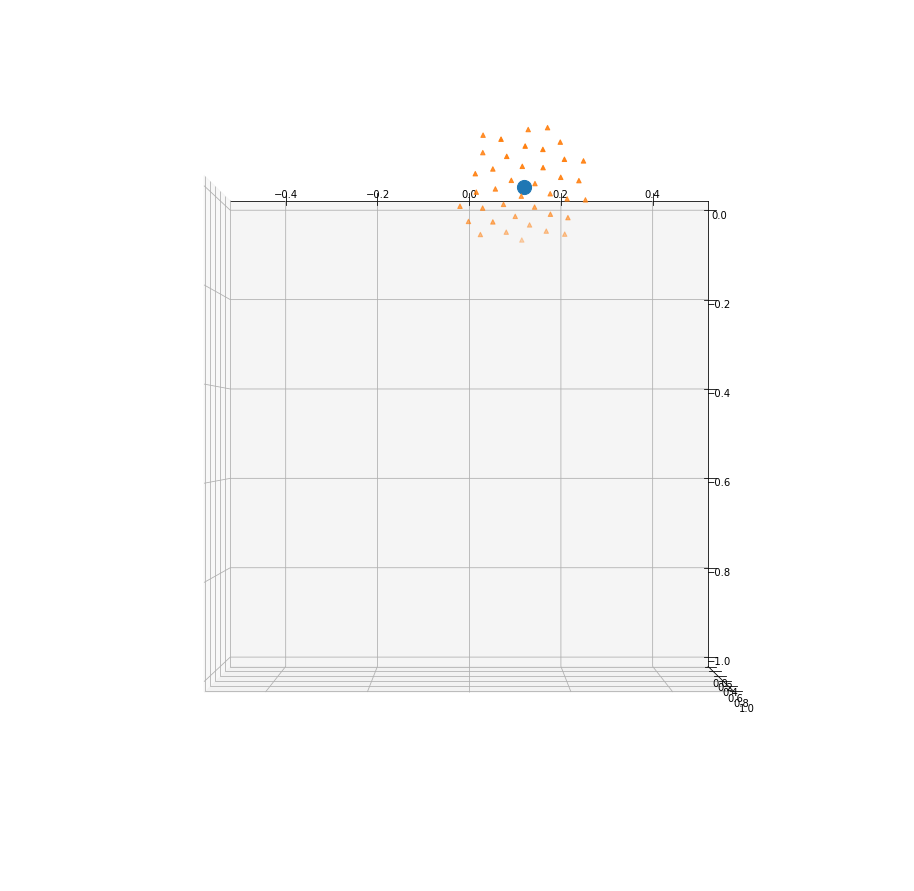

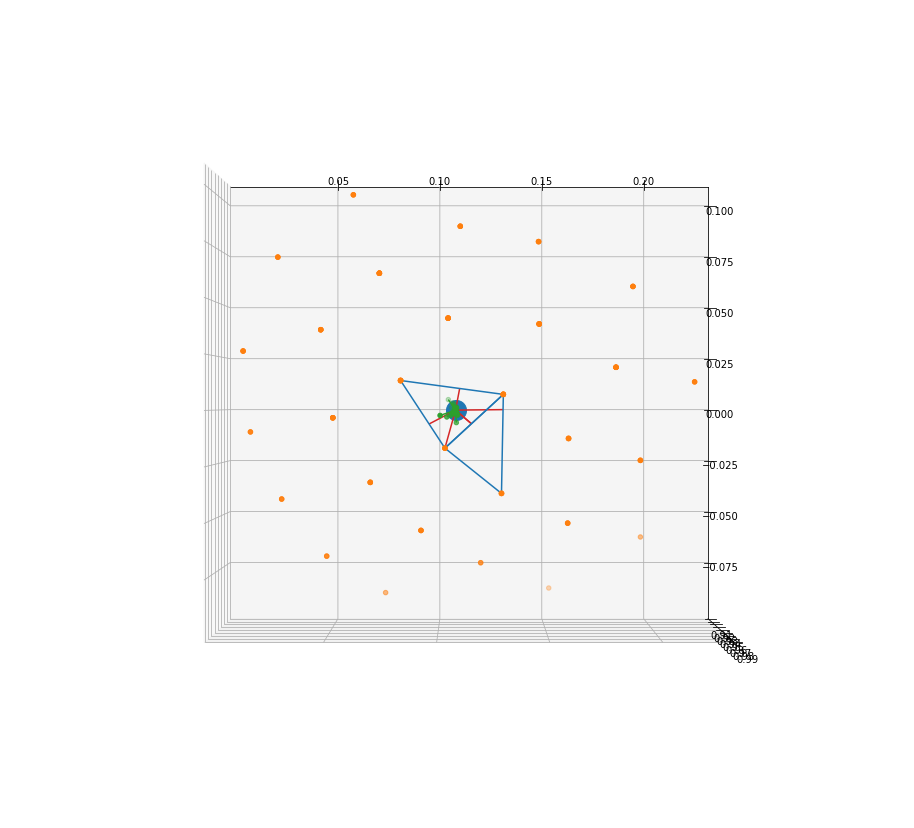

In [52]:
i = 0; j = 0; k = 10
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter3D(Xt[0:k,:, 0], Xt[0:k,:, 1], Xt[0:k,:, 2])
#ax.scatter3D(Xt[:, :, 0], Xt[:, :, 1], Xt[:, :, 2], s=1)
ax.scatter3D(Xt[i, j, 0], Xt[i, j, 1], Xt[i, j, 2], s=200)
ax.scatter3D(Xneigh[i, j, :, 0], Xneigh[i, j, :, 1], Xneigh[i, j, :, 2], marker = '^')
#nTfv = np.logical_not(Tfv)
#ax.scatter3D(Vp[Tfv, 0]/r0, Vp[Tfv, 1]/r0, Vp[Tfv, 2]/r0, s = 1)#, c='C0')
#ax.scatter3D(Vp[nTfv, 0]/r0, Vp[nTfv, 1]/r0, Vp[nTfv, 2]/r0, s = 1)#, c='C1')
ax.view_init(azim=-90, elev=90)
ax.set_zlim3d(0, 1); ax.set_xlim3d(-0.5, 0.5); ax.set_ylim3d(-1, 0)
#ax.set_aspect('equal')

Xs = Xt[i,j,:]
Xf = Fneigh[i,j,...]


d2vmat = d2v(Xs, Xneigh[i,j,...], avg_dist=False)
print('node-node distances:', np.sort(d2vmat)**2)

Xv = Xf.reshape(-1, 3)
Xe = np.vstack([np.stack([Xf[0,:,:], np.roll(Xf[0,:,:], 1, axis=0)], axis=1),
                np.stack([Xf[1,:,:], np.roll(Xf[1,:,:], 1, axis=0)], axis=1)])
tic = time.time()
d2fmat, q = d2f(Xs, Xf, avg_dist=False, debug=True);
toc = time.time()


q = np.squeeze(q)
d2e1, q1, _, _ = d2e(Xs, np.stack([Xf[0,:,:], np.roll(Xf[0,:,:], 1, axis=0)], axis=1), avg_dist=False, debug=True)
d2e2, q2, _, _ = d2e(Xs, np.stack([Xf[1,:,:], np.roll(Xf[1,:,:], 1, axis=0)], axis=1), avg_dist=False, debug=True)
q1 = q1.squeeze(); q2 = q2.squeeze();

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(Xs[..., 0], Xs[..., 1], Xs[..., 2], 'C1',s=400) # nodepoint
ax.scatter3D(Xv[..., 0], Xv[..., 1], Xv[..., 2], 'C0')       # neighbor list
ax.scatter3D(q[..., 0], q[..., 1], q[..., 2], 'C2')          # projection point
#print(q)
#tic = time.time(); d2fmat = d2f(Xs, Xf); toc = time.time()
#print('total distance:', d2fmat, toc-tic, 's')
#tic = time.time(); d2fmat = d2f(Xs, Xf, fasteval=True); toc = time.time()
#print('fast total distance:', d2fmat, toc-tic, 's')
f_cached = generate_fcache(Xf)
tic = time.time(); d2fmat = d2f(Xs, Xf, f_cached=f_cached); toc = time.time()
print('total distance with cache:', d2fmat, toc-tic, 's')
#print(d2e1); print(q1);
#print(d2e2); print(q2);

edges = Line3DCollection(np.hstack([Xe[:,0,:], Xe[:,1,:]]).reshape((-1,2,3)), colors='C0')
ax.add_collection(edges)
#lines_3d = Line3DCollection(np.hstack([np.broadcast_to(Xs, Xv.shape), Xv]).reshape((-1,2,3)), colors='C1')
#ax.add_collection(lines_3d)
projection = Line3DCollection(np.hstack([np.broadcast_to(Xs, q.shape), q]).reshape((-1,2,3)), colors='C2')
ax.add_collection(projection)
projection1 = Line3DCollection(np.hstack([np.broadcast_to(Xs, q1.shape), q1]).reshape((-1,2,3)), colors='C3')
ax.add_collection(projection1)
projection2 = Line3DCollection(np.hstack([np.broadcast_to(Xs, q2.shape), q2]).reshape((-1,2,3)), colors='C3')
ax.add_collection(projection2)

ax.view_init(azim=-90, elev=90)
ax.set_aspect('equal')
plt.show()


We use the solution we obtained from Section 1 `Uvec_real` for the testing:

In [53]:
myalpha = 0.1

In [54]:
print('Calculate node-node distances without weighing...')

tic = time.time()
dist_test = coeffs2dist(U1avec0, Xneigh, lmax=lJmax, X0=X0, Complex=True,debug=True)
toc = time.time()
print(dist_test.min(axis=-1)[:,0])
#print('compare only neighbor list: dist = %.8f, time = %.4f'%(dist_test, toc-tic))

tic = time.time()
dist_test = coeffs2dist(U1avec0, Xneigh, lmax=lJmax, X0=X0, Complex=True, debug=True)
toc = time.time()
print(dist_test.min(axis=-1).mean())
#print('compare only neighbor list: dist = %.8f, time = %.4f'%(dist_test, toc-tic))

tic = time.time()
dist_test = coeffs2dist(U1avec0, Xneigh, lmax=lJmax, X0=X0, Complex=True)
toc = time.time()
print('compare only neighbor list: dist = %.8f, time = %.4f'%(dist_test, toc-tic))

print('Calculate target function using alpha=',myalpha)
tic = time.time()
dist_test = sol2dist(AK_init, Cmat, Dmat, alpha = myalpha, separate=False, Xt=Xneigh, lmax=lJmax, X0=X0)
toc = time.time()
print('compare only neighbor list: dist = %.8f, time = %.4f'%(dist_test, toc-tic))


Calculate node-node distances without weighing...
[4.12942075e-04 4.39097461e-04 3.68272068e-04 2.39775618e-04
 4.39207405e-04 2.79120237e-04 7.22723612e-05 2.90264648e-04
 6.25594973e-05 4.05427604e-04 2.59359286e-04 2.84113359e-04
 3.46861738e-04 2.17017986e-04 1.44165058e-04 4.18269262e-04
 1.61257191e-04 2.78033176e-04 3.54932611e-04 2.81402177e-04
 4.36785977e-04]
0.00028480680886425685
compare only neighbor list: dist = 0.00028481, time = 0.0045
Calculate target function using alpha= 0.1
compare only neighbor list: dist = 0.62885903, time = 0.0067


In [55]:
print('Calculate node-face distances without weighing...')

f_cached = generate_fcache(Fneigh)
tic = time.time()
dist_test = coeffs2dist(U1avec0, Fneigh, f_cached=f_cached, lmax=lJmax, X0=X0, Complex=True, debug=True)
toc = time.time()
print(dist_test.min(axis=-1).mean())
#print('compare only neighbor list: dist = %.8f, time = %.4f'%(dist_test, toc-tic))

f_cached = generate_fcache(Fneigh)
tic = time.time()
dist_test = coeffs2dist(U1avec0, Fneigh, f_cached=f_cached, lmax=lJmax, X0=X0, Complex=True)
toc = time.time()
print('compare only neighbor list: dist = %.8f, time = %.4f'%(dist_test, toc-tic))

print('Calculate target function using alpha=',myalpha)
tic = time.time()
dist_test = sol2dist(AK_init, Cmat, Dmat, alpha=myalpha, Xt=Fneigh, f_cached=f_cached, lmax=lJmax, X0=X0)
toc = time.time()
print('weighted distance: dist = %.8f, time = %.4f'%(dist_test, toc-tic))


Calculate node-face distances without weighing...
3.160789817527175e-05
compare only neighbor list: dist = 0.00003161, time = 0.0258
Calculate target function using alpha= 0.1
weighted distance: dist = 0.62860584, time = 0.0301


### 2.4 Solution by minimizing the shape-shape difference

Then we can optimizing the solution by minimizing the distance:

In [56]:
# minimize the distance by variate coefficients
from scipy.optimize import minimize

tic = time.time()
uvec_min = minimize(coeffs2dist, U1avec0,
                    args=(Xneigh, None, lJmax, X0, True, lat_weights, vert_weight), #, l_weight), 
                    #method='Powell', options={'maxiter':1, 'maxfev':10, 'disp': True})
                    method='CG',options={'maxiter': 1, 'gtol': 1e-4, 'disp': True})
toc = time.time()
print('total time', toc-tic)

print('initial function value: %.8fum'%(np.sqrt(coeffs2dist(U1avec0, Xneigh, lmax=lJmax, X0=X0, Complex=True, 
                                                 lat_weights=lat_weights, vert_weight=vert_weight))*r0))
uiter1 = uvec_min.x
print('iter1 function value: %.8fum'%(np.sqrt(coeffs2dist(uiter1, Xneigh, lmax=lJmax, X0=X0, Complex=True,
                                               lat_weights=lat_weights, vert_weight=vert_weight))*r0))

         Current function value: 0.000056
         Iterations: 1
         Function evaluations: 2650
         Gradient evaluations: 2
total time 7.292949199676514
initial function value: 0.04634193um
iter1 function value: 0.03936760um


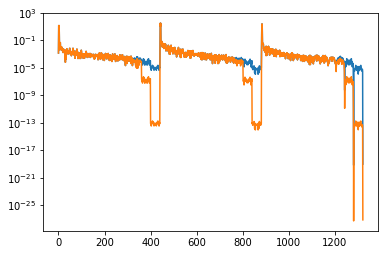

initial function value: 3.4223e-01
initial function value: 0.0510um 184.9700Pa


In [70]:
AKdamp = np.tile(erfc((l_list - lmax_mean)/(lmax_buf/8))/2, 3)
AK_init = spsolve(Dmat, U1avec0.T)*AKdamp
myalpha = 0.1
plt.semilogy(np.abs(AK_init)/AKdamp);
plt.semilogy(np.abs(AK_init)); plt.show()
print('initial function value: %.4e'%sol2dist(AK_init, Cmat, Dmat, myalpha, False, None, lJmax, X0, Xneigh,
                                              lat_weights, vert_weight))
Asol = sol2dist(AK_init, Cmat, Dmat, myalpha, True, None, lJmax, X0, Xneigh,
                lat_weights, vert_weight)
print('initial function value: %.4fum %.4fPa'%(np.sqrt(Asol[0])*r0, np.sqrt(Asol[1])*mu0))
AK_iter = AK_init.copy()
funval = []

         Current function value: 0.220479
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 53.4397394657135
iter111 function value: 3.3139e-01
iter111 function value: 0.1826um 148.0782Pa


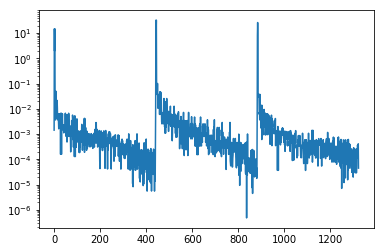

         Current function value: 0.220173
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 49.52630686759949
iter112 function value: 3.2996e-01
iter112 function value: 0.1825um 147.9751Pa


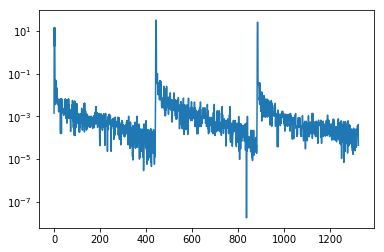

         Current function value: 0.219998
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 55.19528412818909
iter113 function value: 3.2646e-01
iter113 function value: 0.1828um 147.9145Pa


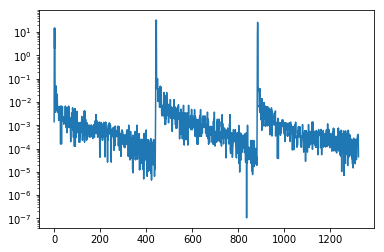

         Current function value: 0.217623
         Iterations: 5
         Function evaluations: 14575
         Gradient evaluations: 11
total time 63.76543664932251
iter114 function value: 3.2454e-01
iter114 function value: 0.1918um 147.0679Pa


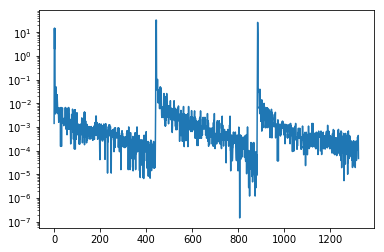

         Current function value: 0.215314
         Iterations: 5
         Function evaluations: 14575
         Gradient evaluations: 11
total time 60.15442132949829
iter115 function value: 3.2375e-01
iter115 function value: 0.1913um 146.2832Pa


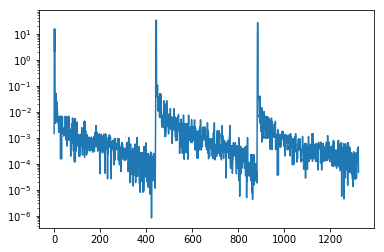

         Current function value: 0.214970
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 50.33609867095947
iter116 function value: 3.2266e-01
iter116 function value: 0.1928um 146.1587Pa


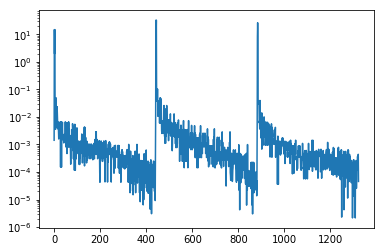

         Current function value: 0.214540
         Iterations: 5
         Function evaluations: 13250
         Gradient evaluations: 10
total time 58.63013958930969
iter117 function value: 3.2133e-01
iter117 function value: 0.1928um 146.0115Pa


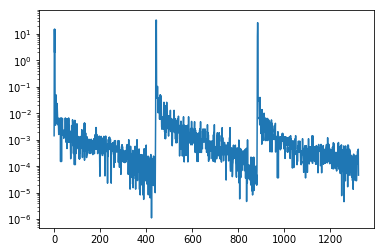

         Current function value: 0.214229
         Iterations: 5
         Function evaluations: 13250
         Gradient evaluations: 10
total time 56.11659860610962
iter118 function value: 3.2023e-01
iter118 function value: 0.1935um 145.9015Pa


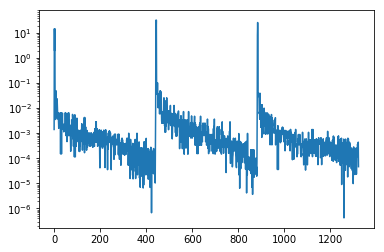

         Current function value: 0.214003
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 55.353841066360474
iter119 function value: 3.1920e-01
iter119 function value: 0.1938um 145.8224Pa


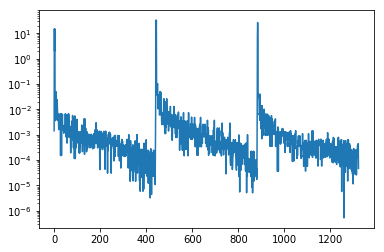

         Current function value: 0.213083
         Iterations: 5
         Function evaluations: 13250
         Gradient evaluations: 10
total time 62.63988471031189
iter120 function value: 3.1862e-01
iter120 function value: 0.1977um 145.4875Pa


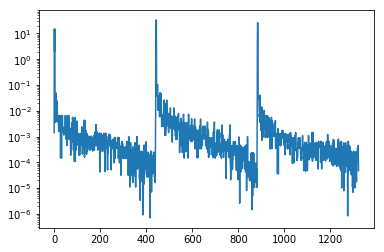

         Current function value: 0.212125
         Iterations: 5
         Function evaluations: 14575
         Gradient evaluations: 11
total time 63.88262224197388
iter121 function value: 3.1818e-01
iter121 function value: 0.1974um 145.1599Pa


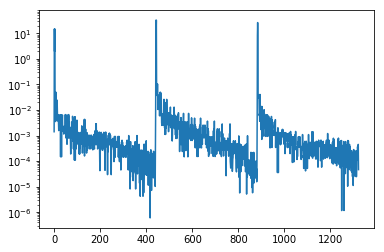

         Current function value: 0.211645
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 56.886473178863525
iter122 function value: 3.1769e-01
iter122 function value: 0.1991um 144.9855Pa


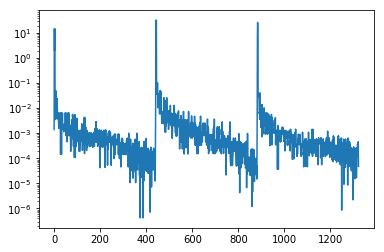

         Current function value: 0.211240
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 51.11654257774353
iter123 function value: 3.1547e-01
iter123 function value: 0.1991um 144.8462Pa


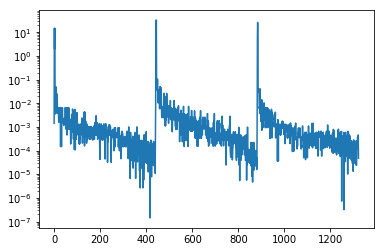

         Current function value: 0.210564
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 51.761027574539185
iter124 function value: 3.1349e-01
iter124 function value: 0.2015um 144.6007Pa


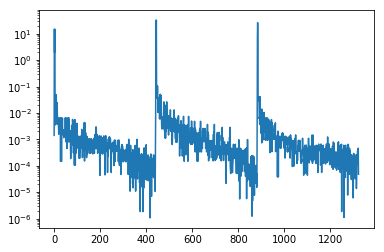

         Current function value: 0.210035
         Iterations: 5
         Function evaluations: 13250
         Gradient evaluations: 10
total time 56.175203800201416
iter125 function value: 3.0681e-01
iter125 function value: 0.2014um 144.4180Pa


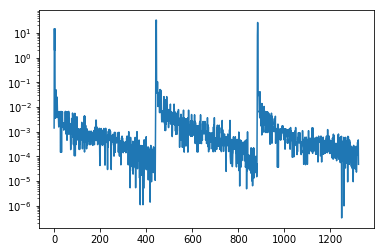

         Current function value: 0.209802
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 52.95918679237366
iter126 function value: 3.0145e-01
iter126 function value: 0.2022um 144.3333Pa


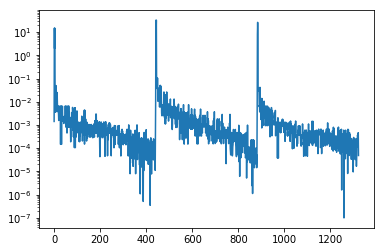

         Current function value: 0.209547
         Iterations: 5
         Function evaluations: 13250
         Gradient evaluations: 10
total time 58.364208698272705
iter127 function value: 2.9852e-01
iter127 function value: 0.2024um 144.2437Pa


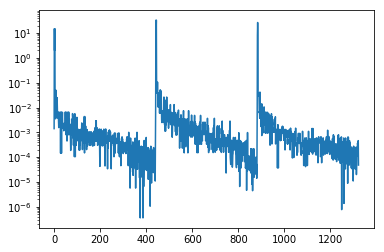

         Current function value: 0.208494
         Iterations: 5
         Function evaluations: 14575
         Gradient evaluations: 11
total time 63.904359340667725
iter128 function value: 2.9591e-01
iter128 function value: 0.2052um 143.8639Pa


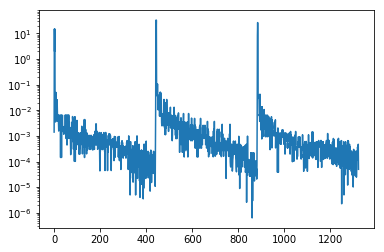

         Current function value: 0.207978
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 54.61672043800354
iter129 function value: 2.9517e-01
iter129 function value: 0.2054um 143.6832Pa


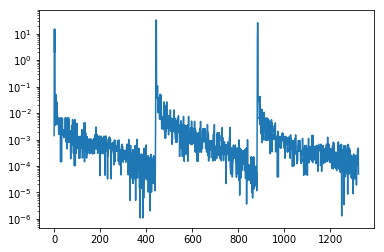

         Current function value: 0.207558
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 55.04764938354492
iter130 function value: 2.9478e-01
iter130 function value: 0.2069um 143.5293Pa


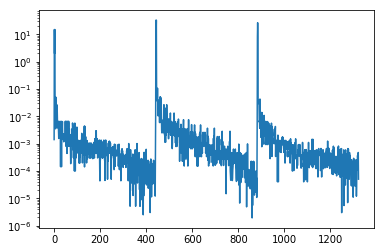

         Current function value: 0.207172
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 52.2425012588501
iter131 function value: 2.9352e-01
iter131 function value: 0.2070um 143.3945Pa


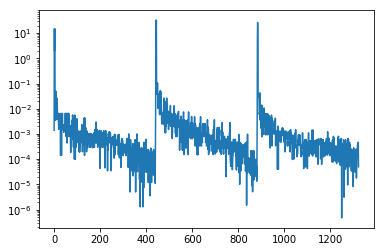

         Current function value: 0.206426
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 51.820521116256714
iter132 function value: 2.9234e-01
iter132 function value: 0.2099um 143.1185Pa


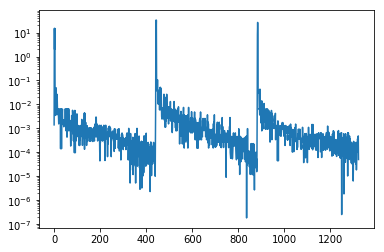

         Current function value: 0.205734
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 52.161633253097534
iter133 function value: 2.9174e-01
iter133 function value: 0.2098um 142.8772Pa


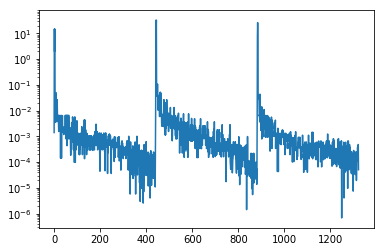

         Current function value: 0.205106
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 50.30377912521362
iter134 function value: 2.9115e-01
iter134 function value: 0.2123um 142.6436Pa


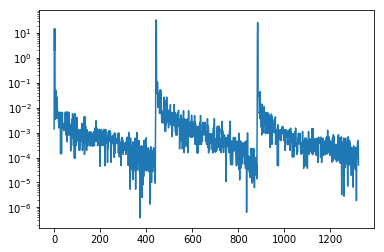

         Current function value: 0.204577
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 52.04649877548218
iter135 function value: 2.9086e-01
iter135 function value: 0.2122um 142.4590Pa


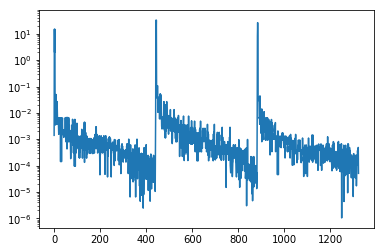

         Current function value: 0.203784
         Iterations: 5
         Function evaluations: 13250
         Gradient evaluations: 10
total time 57.40884470939636
iter136 function value: 2.8914e-01
iter136 function value: 0.2162um 142.1585Pa


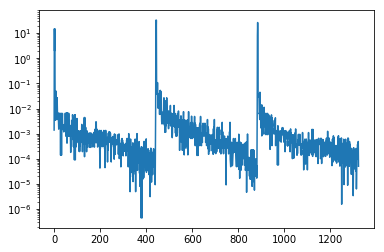

         Current function value: 0.202887
         Iterations: 5
         Function evaluations: 13250
         Gradient evaluations: 10
total time 57.52203369140625
iter137 function value: 2.8802e-01
iter137 function value: 0.2158um 141.8447Pa


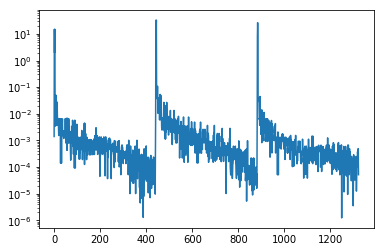

         Current function value: 0.202730
         Iterations: 5
         Function evaluations: 9275
         Gradient evaluations: 7
total time 40.393770694732666
iter138 function value: 2.8740e-01
iter138 function value: 0.2161um 141.7881Pa


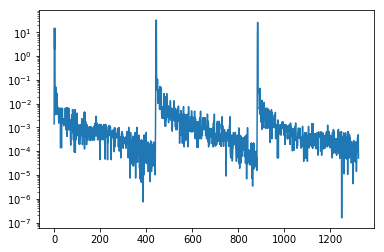

         Current function value: 0.202361
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 51.42328643798828
iter139 function value: 2.8691e-01
iter139 function value: 0.2171um 141.6520Pa


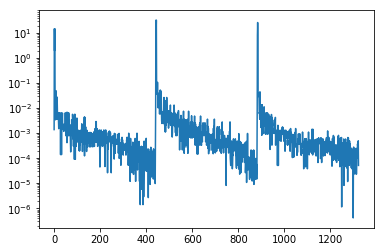

         Current function value: 0.202036
         Iterations: 5
         Function evaluations: 13250
         Gradient evaluations: 10
total time 61.28704571723938
iter140 function value: 2.8646e-01
iter140 function value: 0.2176um 141.5348Pa


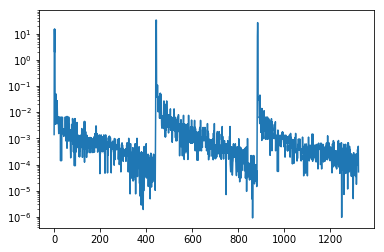

         Current function value: 0.201893
         Iterations: 5
         Function evaluations: 9275
         Gradient evaluations: 7
total time 41.17187476158142
iter141 function value: 2.8604e-01
iter141 function value: 0.2178um 141.4830Pa


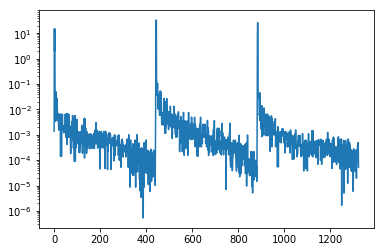

         Current function value: 0.198258
         Iterations: 5
         Function evaluations: 15900
         Gradient evaluations: 12
total time 70.39183807373047
iter142 function value: 2.8557e-01
iter142 function value: 0.2328um 140.1049Pa


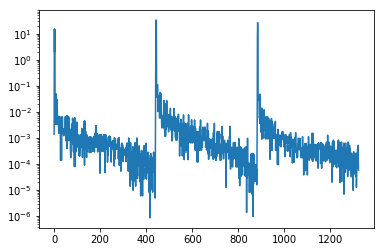

         Current function value: 0.195489
         Iterations: 5
         Function evaluations: 14575
         Gradient evaluations: 11
total time 63.13067078590393
iter143 function value: 2.8534e-01
iter143 function value: 0.2319um 139.1186Pa


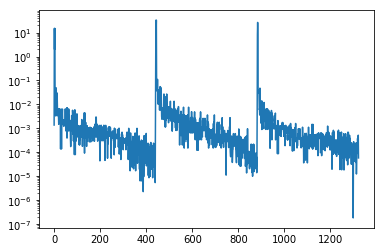

         Current function value: 0.194742
         Iterations: 5
         Function evaluations: 13250
         Gradient evaluations: 10
total time 62.7519953250885
iter144 function value: 2.8491e-01
iter144 function value: 0.2347um 138.8333Pa


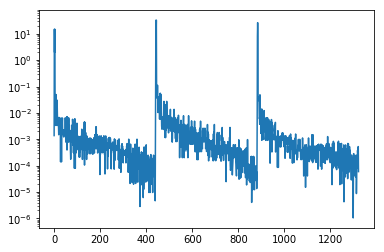

         Current function value: 0.194175
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 50.02037167549133
iter145 function value: 2.8461e-01
iter145 function value: 0.2350um 138.6270Pa


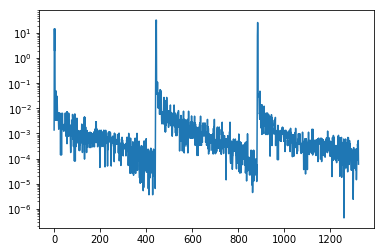

         Current function value: 0.193923
         Iterations: 5
         Function evaluations: 13250
         Gradient evaluations: 10
total time 54.701223611831665
iter146 function value: 2.8430e-01
iter146 function value: 0.2354um 138.5331Pa


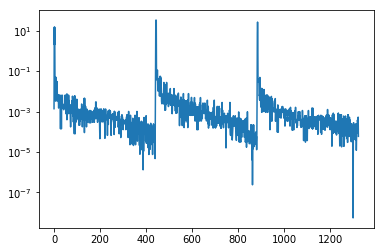

         Current function value: 0.193693
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 50.649619340896606
iter147 function value: 2.8377e-01
iter147 function value: 0.2358um 138.4476Pa


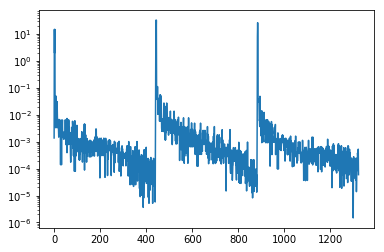

         Current function value: 0.193516
         Iterations: 5
         Function evaluations: 10600
         Gradient evaluations: 8
total time 44.06068563461304
iter148 function value: 2.8325e-01
iter148 function value: 0.2364um 138.3799Pa


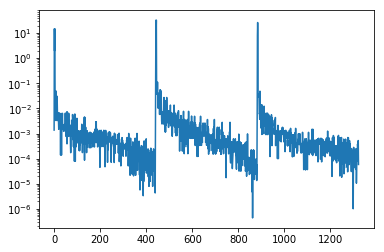

         Current function value: 0.193370
         Iterations: 5
         Function evaluations: 10600
         Gradient evaluations: 8
total time 43.27513241767883
iter149 function value: 2.8256e-01
iter149 function value: 0.2365um 138.3269Pa


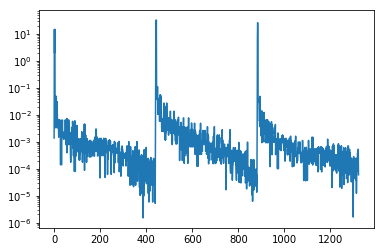

         Current function value: 0.192136
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 49.17428517341614
iter150 function value: 2.8196e-01
iter150 function value: 0.2408um 137.8533Pa


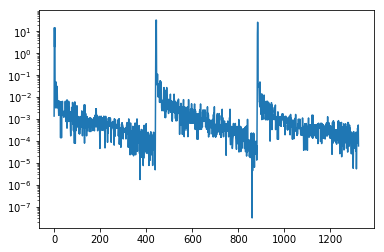

         Current function value: 0.191522
         Iterations: 5
         Function evaluations: 14575
         Gradient evaluations: 11
total time 62.55088543891907
iter151 function value: 2.7453e-01
iter151 function value: 0.2407um 137.6312Pa


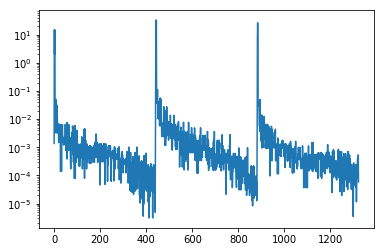

         Current function value: 0.191080
         Iterations: 5
         Function evaluations: 13250
         Gradient evaluations: 10
total time 58.16677141189575
iter152 function value: 2.6759e-01
iter152 function value: 0.2425um 137.4589Pa


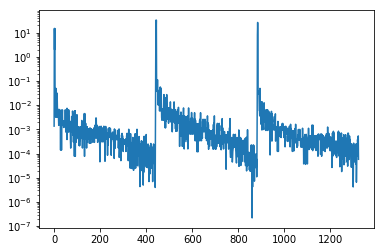

         Current function value: 0.190724
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 55.37397837638855
iter153 function value: 2.6573e-01
iter153 function value: 0.2425um 137.3294Pa


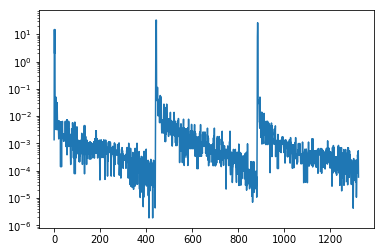

         Current function value: 0.189966
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 54.82745337486267
iter154 function value: 2.6436e-01
iter154 function value: 0.2459um 137.0312Pa


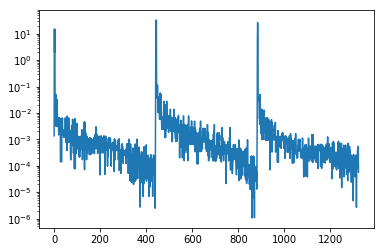

         Current function value: 0.189338
         Iterations: 5
         Function evaluations: 13250
         Gradient evaluations: 10
total time 60.50055408477783
iter155 function value: 2.6393e-01
iter155 function value: 0.2456um 136.8036Pa


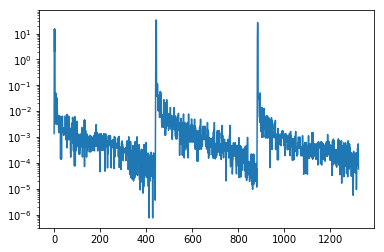

         Current function value: 0.188916
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 52.68158316612244
iter156 function value: 2.6343e-01
iter156 function value: 0.2469um 136.6411Pa


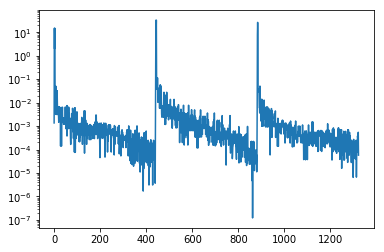

         Current function value: 0.188728
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 52.666640281677246
iter157 function value: 2.6308e-01
iter157 function value: 0.2469um 136.5718Pa


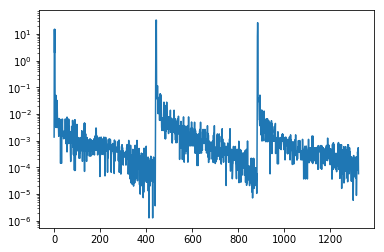

         Current function value: 0.185312
         Iterations: 5
         Function evaluations: 17225
         Gradient evaluations: 13
total time 73.3019380569458
iter158 function value: 2.6265e-01
iter158 function value: 0.2642um 135.1975Pa


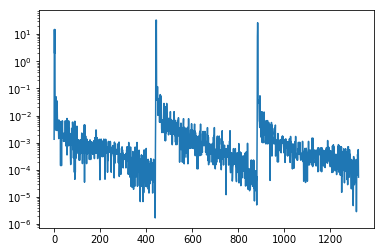

         Current function value: 0.182224
         Iterations: 5
         Function evaluations: 10600
         Gradient evaluations: 8
total time 44.74717307090759
iter159 function value: 2.6216e-01
iter159 function value: 0.2632um 134.0574Pa


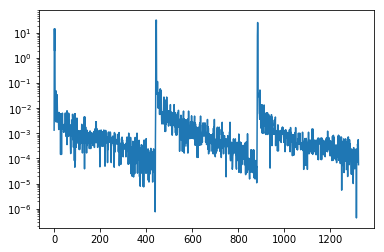

         Current function value: 0.181845
         Iterations: 5
         Function evaluations: 14575
         Gradient evaluations: 11
total time 61.6805739402771
iter160 function value: 2.6196e-01
iter160 function value: 0.2631um 133.9169Pa


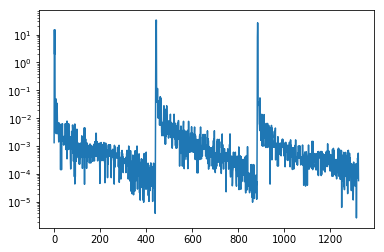

         Current function value: 0.181648
         Iterations: 5
         Function evaluations: 10600
         Gradient evaluations: 8
total time 44.65645503997803
iter161 function value: 2.6161e-01
iter161 function value: 0.2638um 133.8380Pa


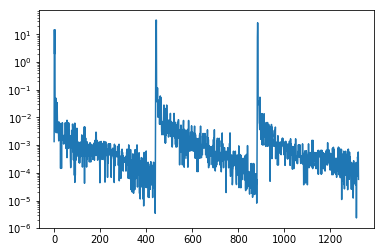

         Current function value: 0.181516
         Iterations: 5
         Function evaluations: 10600
         Gradient evaluations: 8
total time 43.49763631820679
iter162 function value: 2.6097e-01
iter162 function value: 0.2640um 133.7875Pa


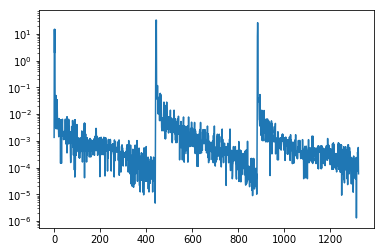

         Current function value: 0.181292
         Iterations: 5
         Function evaluations: 10600
         Gradient evaluations: 8
total time 45.203694343566895
iter163 function value: 2.6044e-01
iter163 function value: 0.2648um 133.6974Pa


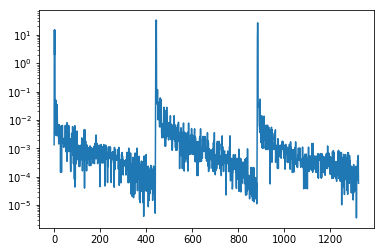

         Current function value: 0.181079
         Iterations: 5
         Function evaluations: 10600
         Gradient evaluations: 8
total time 49.247681617736816
iter164 function value: 2.5924e-01
iter164 function value: 0.2651um 133.6164Pa


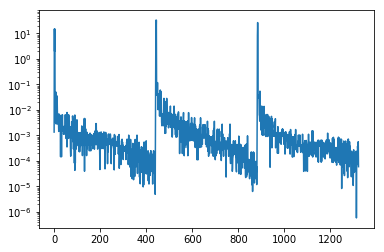

         Current function value: 0.180837
         Iterations: 5
         Function evaluations: 13250
         Gradient evaluations: 10
total time 60.8123562335968
iter165 function value: 2.5805e-01
iter165 function value: 0.2658um 133.5206Pa


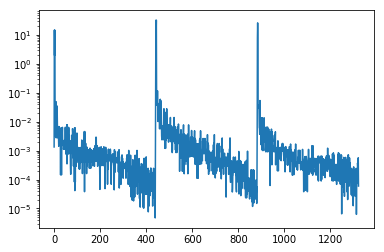

         Current function value: 0.180549
         Iterations: 5
         Function evaluations: 13250
         Gradient evaluations: 10
total time 59.20915150642395
iter166 function value: 2.5711e-01
iter166 function value: 0.2665um 133.4076Pa


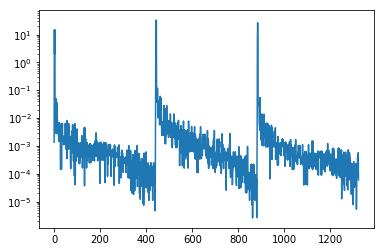

         Current function value: 0.180359
         Iterations: 5
         Function evaluations: 13250
         Gradient evaluations: 10
total time 58.50614547729492
iter167 function value: 2.5618e-01
iter167 function value: 0.2668um 133.3341Pa


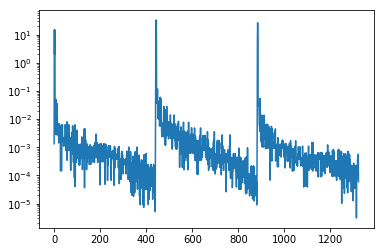

         Current function value: 0.180219
         Iterations: 5
         Function evaluations: 10600
         Gradient evaluations: 8
total time 46.358354568481445
iter168 function value: 2.5534e-01
iter168 function value: 0.2671um 133.2792Pa


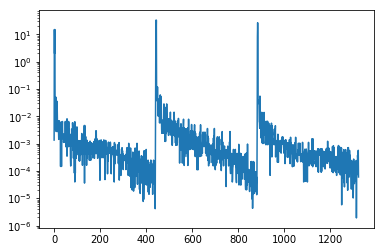

         Current function value: 0.180066
         Iterations: 5
         Function evaluations: 13250
         Gradient evaluations: 10
total time 64.09737467765808
iter169 function value: 2.5453e-01
iter169 function value: 0.2675um 133.2190Pa


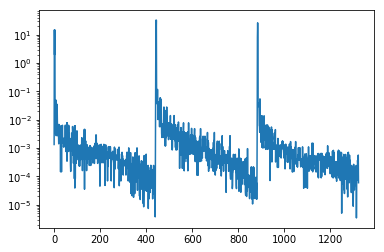

         Current function value: 0.179772
         Iterations: 5
         Function evaluations: 14575
         Gradient evaluations: 11
total time 63.82551598548889
iter170 function value: 2.5397e-01
iter170 function value: 0.2685um 133.1015Pa


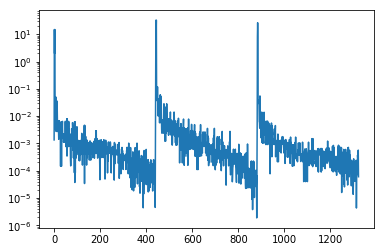

         Current function value: 0.179554
         Iterations: 5
         Function evaluations: 10600
         Gradient evaluations: 8
total time 53.159695863723755
iter171 function value: 2.5338e-01
iter171 function value: 0.2686um 133.0187Pa


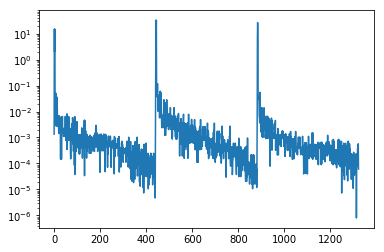

         Current function value: 0.179103
         Iterations: 5
         Function evaluations: 14575
         Gradient evaluations: 11
total time 61.408080101013184
iter172 function value: 2.5304e-01
iter172 function value: 0.2708um 132.8330Pa


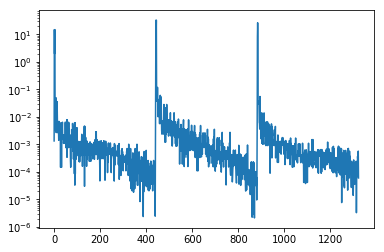

         Current function value: 0.178653
         Iterations: 5
         Function evaluations: 14575
         Gradient evaluations: 11
total time 62.467560052871704
iter173 function value: 2.5271e-01
iter173 function value: 0.2708um 132.6638Pa


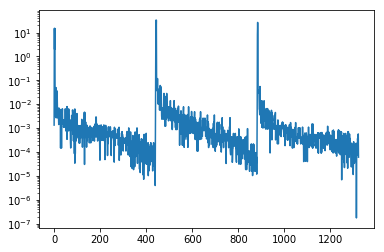

         Current function value: 0.178423
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 51.335195541381836
iter174 function value: 2.5247e-01
iter174 function value: 0.2721um 132.5673Pa


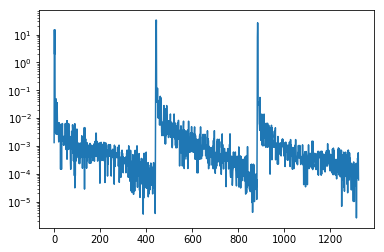

         Current function value: 0.178063
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 51.08273458480835
iter175 function value: 2.5137e-01
iter175 function value: 0.2722um 132.4306Pa


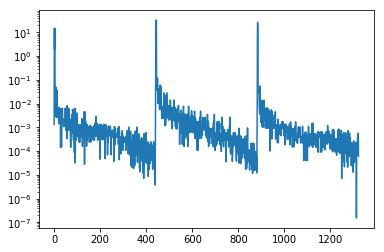

         Current function value: 0.177933
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 52.39670515060425
iter176 function value: 2.5031e-01
iter176 function value: 0.2726um 132.3783Pa


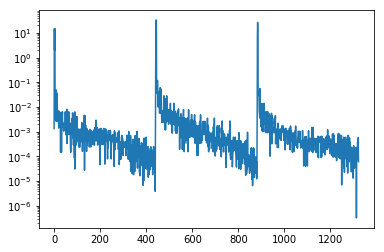

         Current function value: 0.177801
         Iterations: 5
         Function evaluations: 13250
         Gradient evaluations: 10
total time 59.464415073394775
iter177 function value: 2.4970e-01
iter177 function value: 0.2729um 132.3264Pa


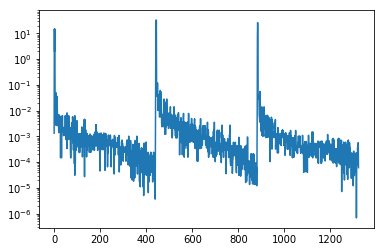

         Current function value: 0.177492
         Iterations: 5
         Function evaluations: 13250
         Gradient evaluations: 10
total time 58.018157720565796
iter178 function value: 2.4915e-01
iter178 function value: 0.2739um 132.2020Pa


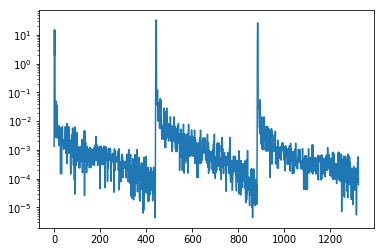

         Current function value: 0.177309
         Iterations: 5
         Function evaluations: 10600
         Gradient evaluations: 8
total time 47.50023603439331
iter179 function value: 2.4829e-01
iter179 function value: 0.2741um 132.1311Pa


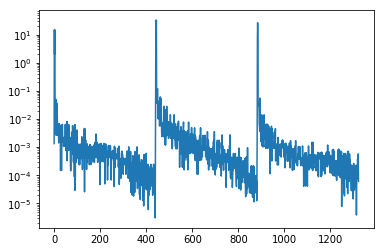

         Current function value: 0.177175
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 53.37658381462097
iter180 function value: 2.4759e-01
iter180 function value: 0.2746um 132.0771Pa


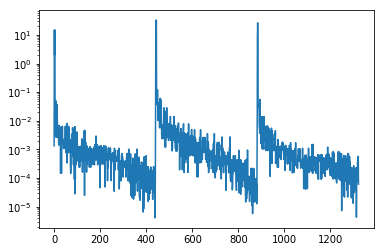

         Current function value: 0.177040
         Iterations: 5
         Function evaluations: 10600
         Gradient evaluations: 8
total time 47.01066255569458
iter181 function value: 2.4621e-01
iter181 function value: 0.2748um 132.0244Pa


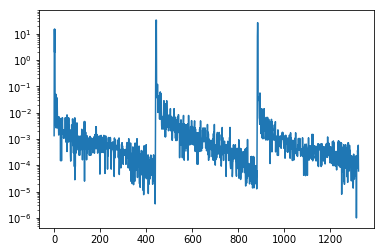

         Current function value: 0.176887
         Iterations: 5
         Function evaluations: 10600
         Gradient evaluations: 8
total time 48.20118474960327
iter182 function value: 2.4502e-01
iter182 function value: 0.2752um 131.9633Pa


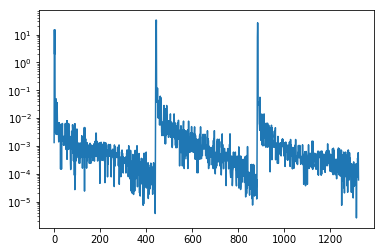

         Current function value: 0.176610
         Iterations: 5
         Function evaluations: 13250
         Gradient evaluations: 10
total time 63.51210975646973
iter183 function value: 2.4470e-01
iter183 function value: 0.2761um 131.8512Pa


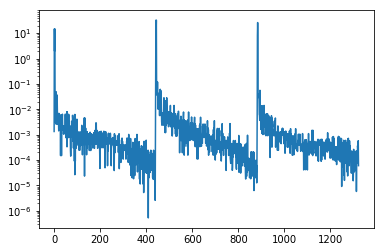

         Current function value: 0.176344
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 54.03044533729553
iter184 function value: 2.4427e-01
iter184 function value: 0.2765um 131.7476Pa


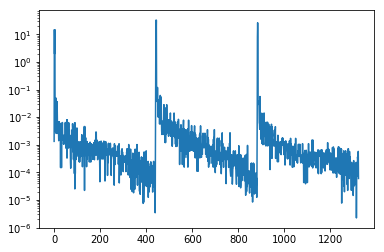

         Current function value: 0.175896
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 53.349162578582764
iter185 function value: 2.4401e-01
iter185 function value: 0.2783um 131.5632Pa


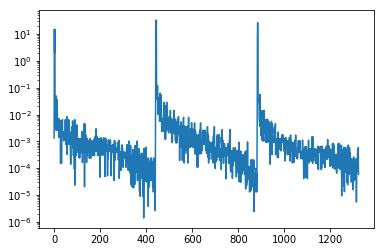

         Current function value: 0.175456
         Iterations: 5
         Function evaluations: 13250
         Gradient evaluations: 10
total time 58.983010053634644
iter186 function value: 2.4318e-01
iter186 function value: 0.2786um 131.3935Pa


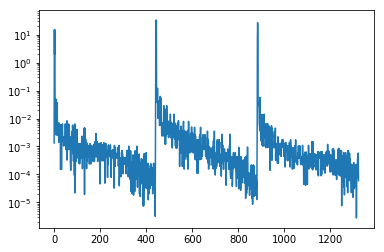

         Current function value: 0.168839
         Iterations: 5
         Function evaluations: 15900
         Gradient evaluations: 12
total time 70.05734133720398
iter187 function value: 2.4261e-01
iter187 function value: 0.3083um 128.6059Pa


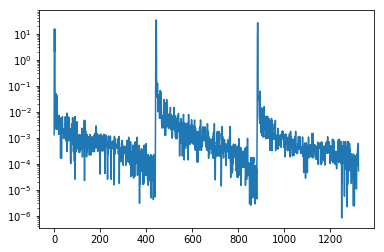

         Current function value: 0.164200
         Iterations: 5
         Function evaluations: 14575
         Gradient evaluations: 11
total time 61.79460144042969
iter188 function value: 2.4235e-01
iter188 function value: 0.3085um 126.7878Pa


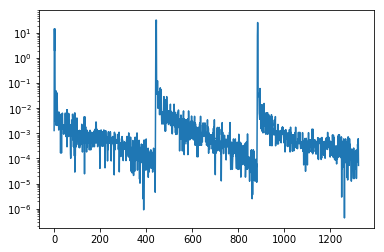

         Current function value: 0.163829
         Iterations: 5
         Function evaluations: 13250
         Gradient evaluations: 10
total time 58.43069624900818
iter189 function value: 2.4216e-01
iter189 function value: 0.3099um 126.6291Pa


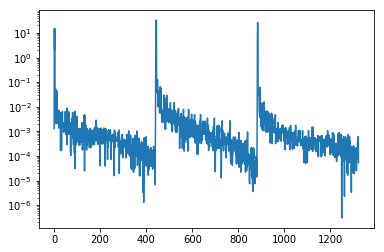

         Current function value: 0.163582
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 54.1754047870636
iter190 function value: 2.4176e-01
iter190 function value: 0.3102um 126.5290Pa


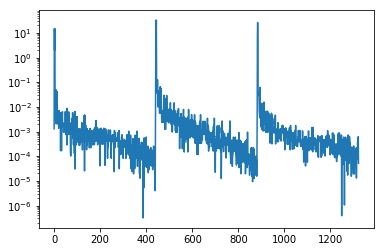

         Current function value: 0.163456
         Iterations: 5
         Function evaluations: 10600
         Gradient evaluations: 8
total time 46.49155282974243
iter191 function value: 2.4145e-01
iter191 function value: 0.3104um 126.4777Pa


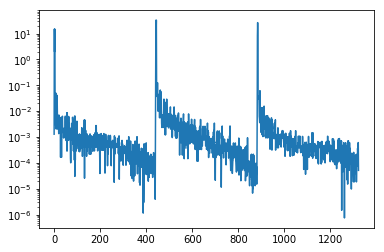

         Current function value: 0.163269
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 52.492191791534424
iter192 function value: 2.4108e-01
iter192 function value: 0.3110um 126.3978Pa


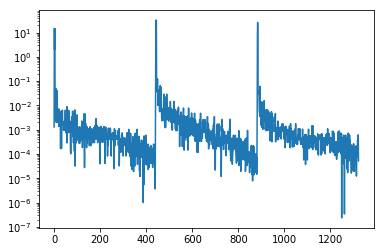

         Current function value: 0.163120
         Iterations: 5
         Function evaluations: 13250
         Gradient evaluations: 10
total time 59.85801362991333
iter193 function value: 2.4075e-01
iter193 function value: 0.3113um 126.3369Pa


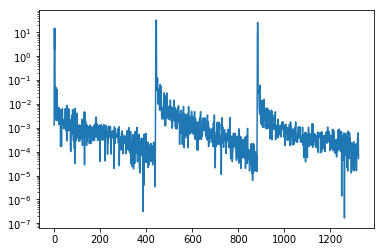

         Current function value: 0.162173
         Iterations: 5
         Function evaluations: 15900
         Gradient evaluations: 12
total time 68.55331683158875
iter194 function value: 2.3912e-01
iter194 function value: 0.3160um 125.9184Pa


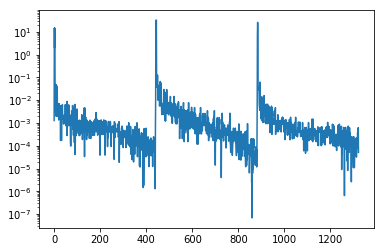

         Current function value: 0.161242
         Iterations: 5
         Function evaluations: 14575
         Gradient evaluations: 11
total time 63.562838077545166
iter195 function value: 2.3800e-01
iter195 function value: 0.3161um 125.5473Pa


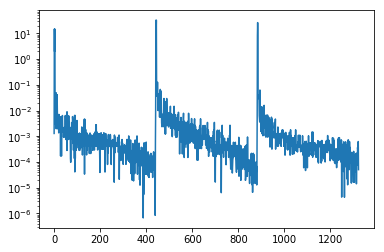

         Current function value: 0.160689
         Iterations: 5
         Function evaluations: 14575
         Gradient evaluations: 11
total time 65.16997170448303
iter196 function value: 2.3757e-01
iter196 function value: 0.3191um 125.2997Pa


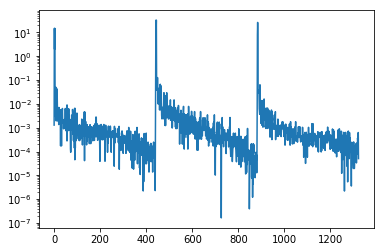

         Current function value: 0.160101
         Iterations: 5
         Function evaluations: 14575
         Gradient evaluations: 11
total time 63.48341631889343
iter197 function value: 2.3711e-01
iter197 function value: 0.3192um 125.0641Pa


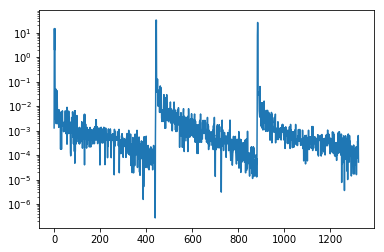

         Current function value: 0.159963
         Iterations: 5
         Function evaluations: 10600
         Gradient evaluations: 8
total time 46.64042019844055
iter198 function value: 2.3684e-01
iter198 function value: 0.3196um 125.0046Pa


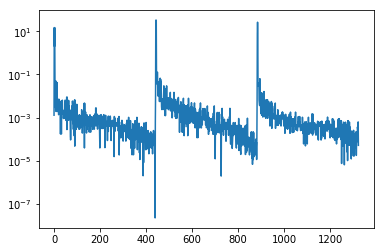

         Current function value: 0.159826
         Iterations: 5
         Function evaluations: 10600
         Gradient evaluations: 8
total time 46.745975494384766
iter199 function value: 2.3613e-01
iter199 function value: 0.3200um 124.9468Pa


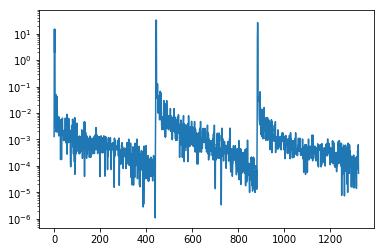

         Current function value: 0.159695
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 52.3975350856781
iter200 function value: 2.3545e-01
iter200 function value: 0.3204um 124.8905Pa


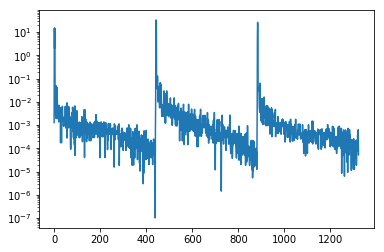

         Current function value: 0.159579
         Iterations: 5
         Function evaluations: 10600
         Gradient evaluations: 8
total time 46.704245805740356
iter201 function value: 2.3519e-01
iter201 function value: 0.3206um 124.8423Pa


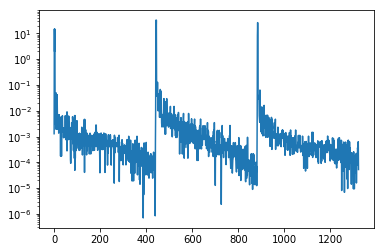

         Current function value: 0.159456
         Iterations: 5
         Function evaluations: 10600
         Gradient evaluations: 8
total time 47.20931029319763
iter202 function value: 2.3494e-01
iter202 function value: 0.3209um 124.7897Pa


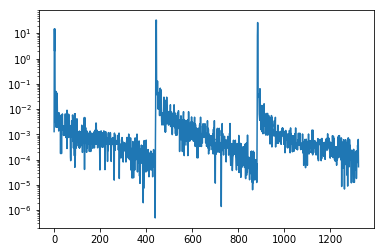

         Current function value: 0.159305
         Iterations: 5
         Function evaluations: 10600
         Gradient evaluations: 8
total time 46.233646392822266
iter203 function value: 2.3438e-01
iter203 function value: 0.3214um 124.7241Pa


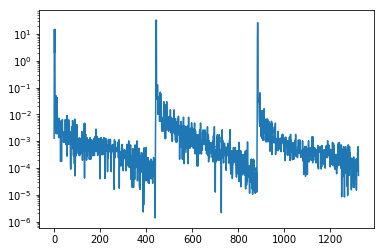

         Current function value: 0.159163
         Iterations: 5
         Function evaluations: 10600
         Gradient evaluations: 8
total time 45.50713872909546
iter204 function value: 2.3400e-01
iter204 function value: 0.3217um 124.6647Pa


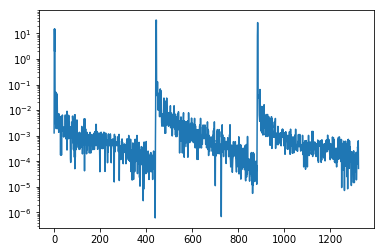

         Current function value: 0.154818
         Iterations: 5
         Function evaluations: 17225
         Gradient evaluations: 13
total time 77.01373744010925
iter205 function value: 2.3326e-01
iter205 function value: 0.3458um 122.6723Pa


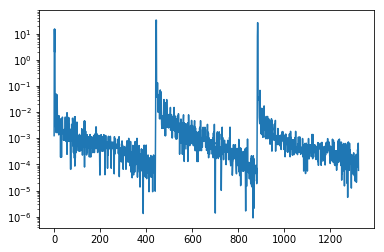

         Current function value: 0.150694
         Iterations: 5
         Function evaluations: 14575
         Gradient evaluations: 11
total time 66.35146498680115
iter206 function value: 2.3263e-01
iter206 function value: 0.3455um 120.9831Pa


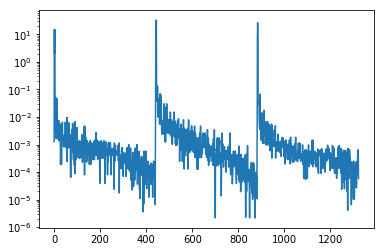

         Current function value: 0.150472
         Iterations: 5
         Function evaluations: 10600
         Gradient evaluations: 8
total time 47.61323642730713
iter207 function value: 2.3226e-01
iter207 function value: 0.3463um 120.8827Pa


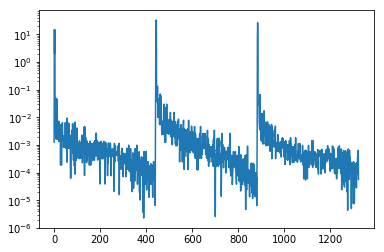

         Current function value: 0.150332
         Iterations: 5
         Function evaluations: 11925
         Gradient evaluations: 9
total time 52.33952188491821
iter208 function value: 2.3191e-01
iter208 function value: 0.3466um 120.8218Pa


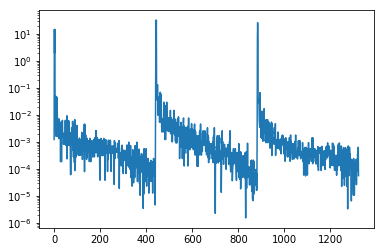

         Current function value: 0.150197
         Iterations: 5
         Function evaluations: 13250
         Gradient evaluations: 10
total time 58.41291093826294
iter209 function value: 2.3171e-01
iter209 function value: 0.3470um 120.7617Pa


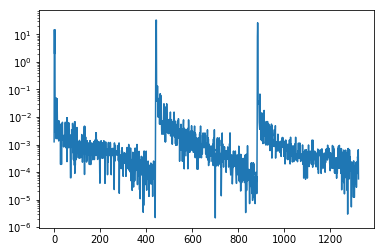

         Current function value: 0.149962
         Iterations: 5
         Function evaluations: 13250
         Gradient evaluations: 10
total time 59.071839332580566
iter210 function value: 2.3128e-01
iter210 function value: 0.3479um 120.6553Pa


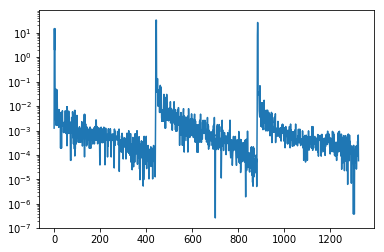

In [74]:
for i in range(100):

    tic = time.time()
    AK_min = minimize(sol2dist, AK_iter,
                        args=(Cmat, Dmat, myalpha, False, None, lJmax, X0, Xneigh, lat_weights, vert_weight),
                        #method='Powell', options={'maxiter':1, 'maxfev':10, 'disp': True})
                        method='CG',options={'maxiter': 5, 'gtol': 1e-4, 'disp': True})
    toc = time.time()
    print('total time', toc-tic)
    funval.append(sol2dist(AK_min.x, Cmat, Dmat, myalpha, False, None, lJmax, X0, Xneigh,
                           lat_weights, vert_weight))
    print('iter%d function value: %.4e'%(len(funval), funval[i]))
    Asol = sol2dist(AK_min.x, Cmat, Dmat, myalpha, True, None, lJmax, X0, Xneigh,
                    lat_weights, vert_weight)
    print('iter%d function value: %.4fum %.4fPa'%(len(funval), np.sqrt(Asol[0])*r0, np.sqrt(Asol[1])*mu0))
    plt.semilogy(np.abs(AK_min.x)); plt.show(); AK_iter = AK_min.x;

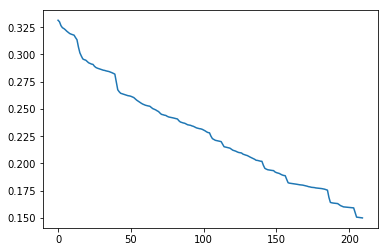

In [76]:
plt.plot(funval); plt.show()

In [113]:
# minimize the distance by variate coefficients
from scipy.optimize import minimize

tic = time.time()
uvec_min = minimize(coeffs2dist, U1avec0,
                    args=(Fneigh, f_cached, lJmax, X0, True), # lat_weights, vert_weight), #, l_weight), 
                    #method='Powell', options={'maxiter':1, 'maxfev': 10, 'disp': True})
                    method='CG',options={'maxiter': 2, 'gtol': 1e-4, 'disp': True})
toc = time.time()
print('total time', toc-tic)

print('initial function value: %.4e'%coeffs2dist(U1avec0, Fneigh,f_cached=f_cached, lmax=lJmax, X0=X0, Complex=True))
uiter1 = uvec_min.x
print('iter1 function value: %.4e'%coeffs2dist(uiter1, Fneigh, f_cached=f_cached, lmax=lJmax, X0=X0, Complex=True))

         Current function value: 0.000021
         Iterations: 2
         Function evaluations: 6625
         Gradient evaluations: 5
total time 182.29333901405334
initial function value: 3.1608e-05
iter1 function value: 2.0892e-05


In [126]:
tic = time.time()
AK_min = minimize(sol2dist, AK_init,
                    args=(Cmat, Dmat, myalpha, False, f_cached, lJmax, X0, Fneigh),
                    #method='Powell', options={'maxiter':1, 'maxfev':10, 'disp': True})
                    method='CG',options={'maxiter': 1, 'gtol': 1e-4, 'disp': True})
toc = time.time()
print('total time', toc-tic)
print('initial function value: %.4e'%sol2dist(AK_init, Cmat, Dmat, myalpha, False, f_cached, lJmax, X0, Fneigh))
print('iter1 function value: %.4e'%sol2dist(AK_min.x, Cmat, Dmat, myalpha, False, f_cached, lJmax, X0, Fneigh))

         Current function value: 0.000028
         Iterations: 1
         Function evaluations: 3975
         Gradient evaluations: 3
total time 105.60138082504272
initial function value: 3.1608e-05
iter1 function value: 2.7500e-05


In [114]:
Uvec1 = uvec_min.x; Tvec1 = Uvec2Tvec(Uvec1, Cmat, Dmat)
print('Displacement and Traction in Cartesian Coordinates...')
umesh1 = SHVec2mesh(Uvec1, lmax=lJmax, SphCoord=False, Complex=True)
tmesh1 = SHVec2mesh(Tvec1*mu0, lmax=lJmax, SphCoord=False, Complex=True)
umesh1_fine = SHVec2mesh(Uvec1, lmax=lmax_plot, SphCoord=False, Complex=True)
tmesh1_fine = SHVec2mesh(Tvec1*mu0, lmax=lmax_plot, SphCoord=False, Complex=True)
Xt = X0 + umesh1

Time: 0.0075s
Displacement and Traction in Cartesian Coordinates...


# Note that `umesh` and `tmesh` here are normalized on the unit sphere

Visualize the nodes in 3D...


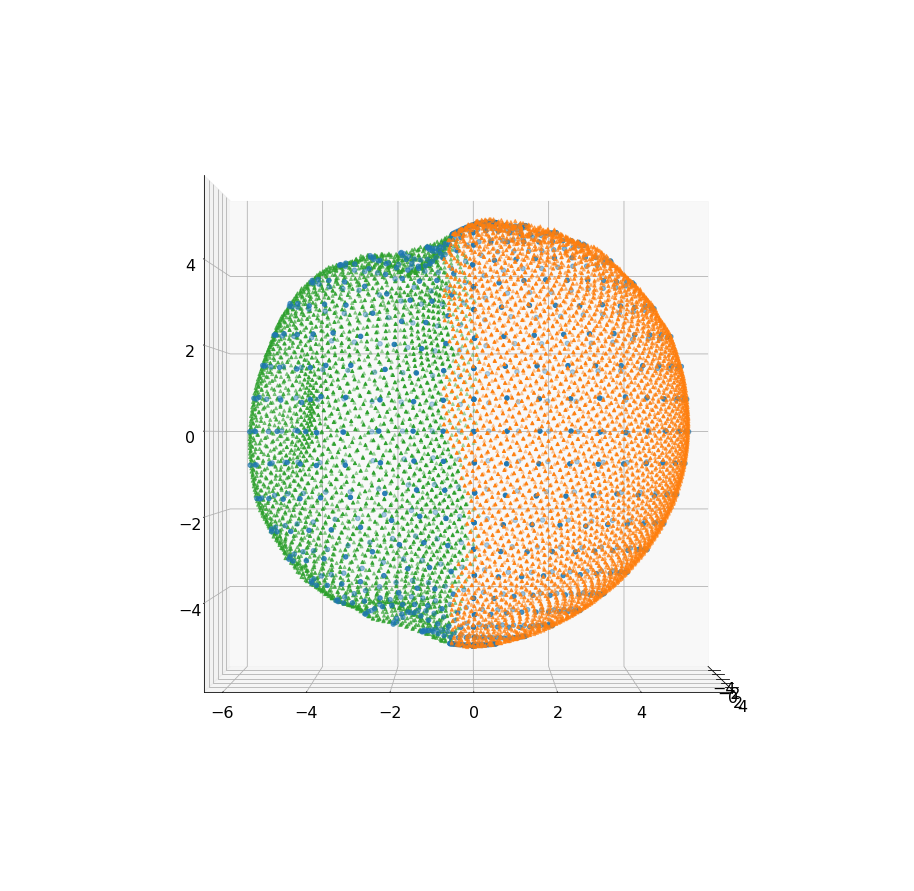

Visualize the shape in 3D...


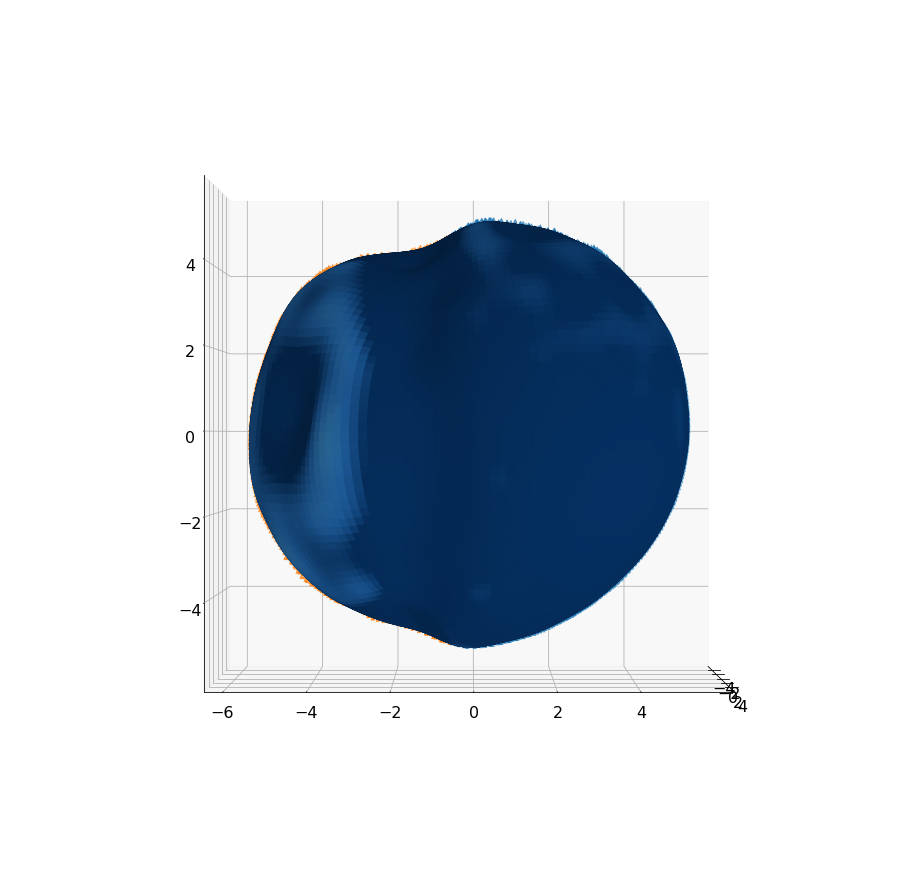

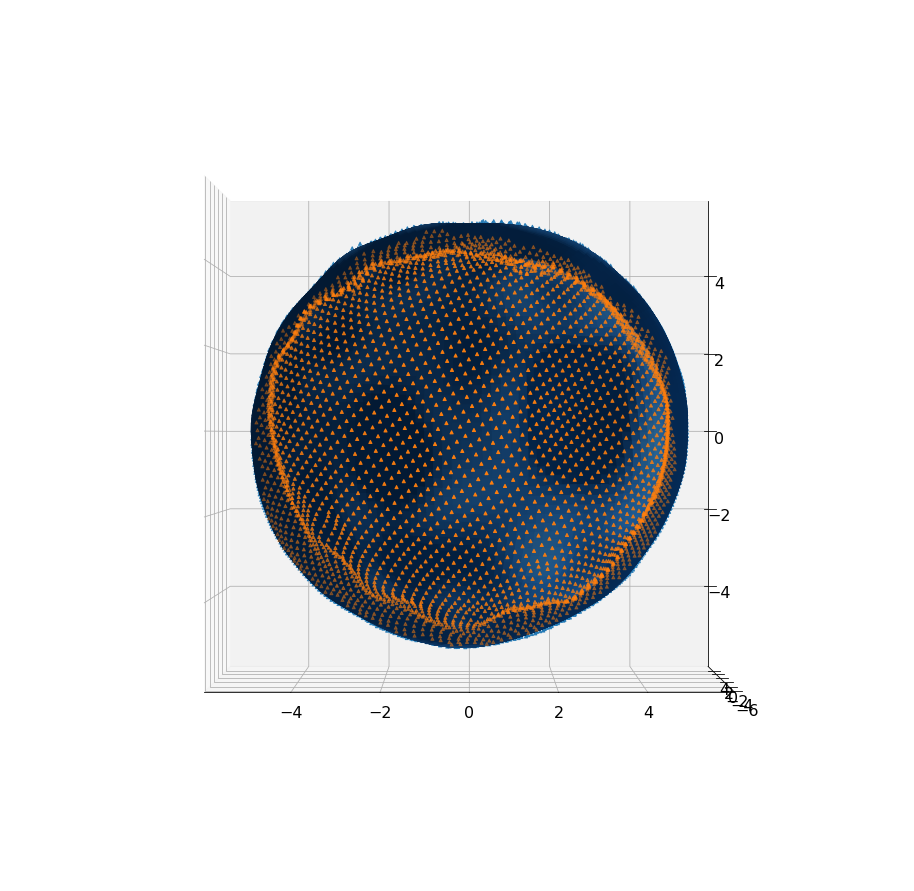

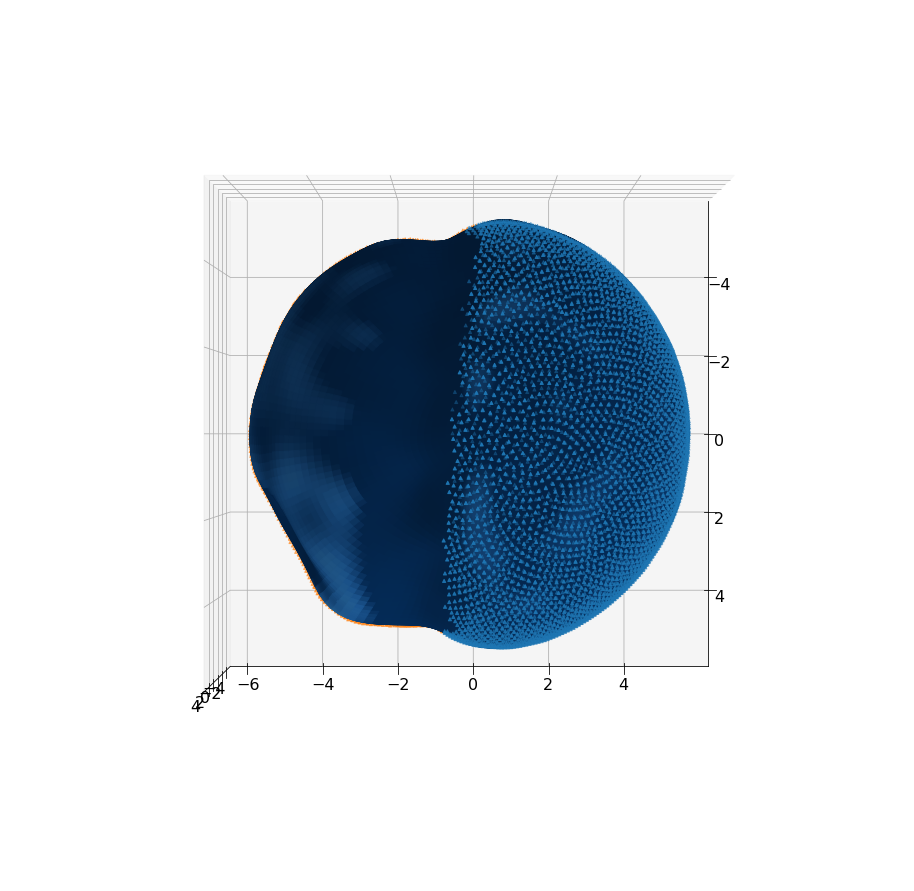

In [115]:
print('Visualize the nodes in 3D...')
fig, ax = visSH3d(umesh1, cmesh=tmesh1, r0=r0, show=False, elevation=0, azimuth=0, surface=False)
nTfv = np.logical_not(Tfv)
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)
plt.show()
print('Visualize the shape in 3D...')
fig, ax = visSH3d(umesh1_fine, cmesh=tmesh1_fine, r0=r0, show=False, elevation=0, azimuth=0, surface=True)
nTfv = np.logical_not(Tfv)
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)
plt.show()
fig, ax = visSH3d(umesh1_fine, cmesh=tmesh1_fine, r0=r0, show=False, elevation=0, azimuth=-90, surface=True)
nTfv = np.logical_not(Tfv)
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)
plt.show()
fig, ax = visSH3d(umesh1_fine, cmesh=tmesh1_fine, r0=r0, show=False, elevation=90, azimuth=0, surface=True)
nTfv = np.logical_not(Tfv)
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)
plt.show()

Visualize the neighbor list on deformed shape:

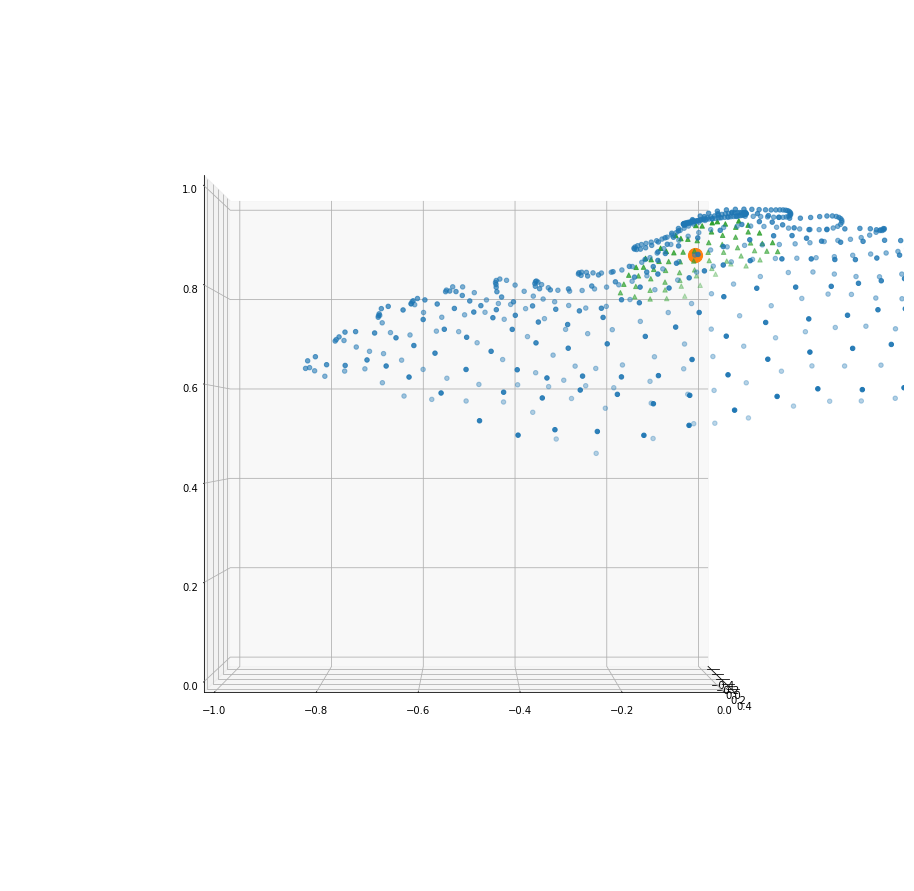

In [38]:
i = 3; j = 31; k = 10
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(Xt[0:k,:, 0], Xt[0:k,:, 1], Xt[0:k,:, 2])
#ax.scatter3D(Xt[:, :, 0], Xt[:, :, 1], Xt[:, :, 2], s=1)
ax.scatter3D(Xt[i, j, 0], Xt[i, j, 1], Xt[i, j, 2], s=200)
ax.scatter3D(Xneigh[i, j, :, 0], Xneigh[i, j, :, 1], Xneigh[i, j, :, 2], marker = '^')
#nTfv = np.logical_not(Tfv)
#ax.scatter3D(Vp[Tfv, 0]/r0, Vp[Tfv, 1]/r0, Vp[Tfv, 2]/r0, s = 1)#, c='C0')
#ax.scatter3D(Vp[nTfv, 0]/r0, Vp[nTfv, 1]/r0, Vp[nTfv, 2]/r0, s = 1)#, c='C1')
ax.view_init(azim=0, elev=0)
ax.set_zlim3d(0, 1); ax.set_xlim3d(-0.5, 0.5); ax.set_ylim3d(-1, 0)
#ax.set_aspect('equal')

plt.show()

## 3. Optimize the solution in the solution space to satisfy the mixed BC

The problem actually includes a mixed BC on shape and traction. In order to optimize the two targets together, we use the vector $a^{(K)}$ as the parameters, and we can obtain the traction and shape by superposing the fundamental solutions

$$
\mathbf{T}=a^{(K)}\mathbf{T}^{(K)}\\
\mathbf{u}=a^{(K)}\mathbf{u}^{(K)}
$$
then the shape is calculated as $\mathbf{x}=\mathbf{X}+\mathbf{u}$.

The target function: to do

We first find the nodes that are on the traction-free boundary

In [39]:
x0 = X0 + umesh1
dist2mat = np.linalg.norm(x0[..., np.newaxis, :] - Vp/r0, axis=-1)
arg_list_x = dist2mat.argmin(axis=-1)
isTfv = Tfv[arg_list_x]

print(umesh1.shape, X0.shape, isTfv.shape)

(31, 61, 3) (31, 61, 3) (31, 61)


Then we optimize the target function:

$$
f_{\text{diff}}={D(x;x_0)\over r_0}+\alpha{D_T(T;\partial\Omega)\over \mu}+\beta{\|T_{\text{shear}}\|\over\mu}
$$

The parameters $\alpha$ and $\beta$ are selected as:

In [40]:
alpha = 0.5; beta = 0.5;

In [68]:
Q = TransMat(lJmax=lJmax)           # transformation matrix from Cartesian to Spherical Coordinates
l_list, m_list = LM_list(lJmax)
#l_weight = l_list**2; 
ndamp = ((lJmax+1)**2 - (lJmax+1-lmax_buf)**2)*3
l_weight = l_list - (lJmax - lmax_buf); l_weight[l_weight < 0] = 0; l_weight = 100**(l_weight) - 1;
A_weight = np.tile(l_weight, 3)
print(A_weight.shape)

## original with bugs
def sol2dist(aK, Cmat, Dmat, alpha = 0.05, separate=False, noshear=0):
    Tvec = Cmat.dot(aK)
    Uvec = Dmat.dot(aK)
    nvec = (lJmax+1)**2
    ucvec = Uvec.reshape(3, -1)
    tcvec = Tvec.reshape(3, -1)
    # expand the displacement and traction field onto a mesh
    umesh = np.empty((lJmax+1, 2*lJmax+1, 3))
    tmesh = np.empty((lJmax+1, 2*lJmax+1, 3))
    for k in range(3):
        ucilm = SHVectorToCilm(ucvec[k, :])
        ugrid = pyshtools.SHCoeffs.from_array(ucilm).expand('GLQ')
        umesh[..., k] = ugrid.to_array().real
        tcilm = SHVectorToCilm(tcvec[k, :])
        tgrid = pyshtools.SHCoeffs.from_array(tcilm).expand('GLQ')
        tmesh[..., k] = tgrid.to_array().real
    Xs = X0 + umesh # + u0.real
    
    d2surf = np.sum((Xs[..., np.newaxis, :]-Xneigh)**2*vert_weight, axis=-1).min(axis=-1)
    Udist = np.sqrt(np.mean(d2surf*lat_weights))
    tvalues = np.sum(tmesh[isTfv, :]**2*vert_weight, axis=-1)
    Tdist = np.sqrt(np.mean(tvalues*lat_weights[isTfv]))
    if separate:
        return (Udist, Tdist, 0)#, regularization)
    return (Udist + alpha*Tdist)*1e3

(2883,)


Residual: 1.2196050172730006e-10
(0.00879762892097415, 1.490584339499615, 0)


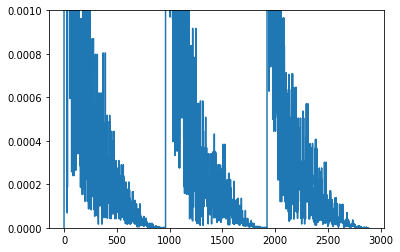

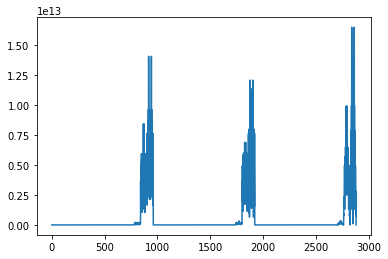

1630690209032908.5
fitting for method 2: 0.04621747 microns, 149.0584 Pa; reg: 0.0000; eval time: 0.0127s


In [69]:
from SHUtil import LM_list

A = lsqr(Cmat, T1avec0.T, atol=0, btol=0, conlim=0)
Ainf = A[0]
print('Residual:', A[3])


tic = time.time()
Asol = sol2dist(AK, Cmat, Dmat, alpha=alpha, separate=True, noshear=0)
toc = time.time()
print(Asol)
plt.plot(np.abs(Ainf)); plt.ylim(0,0.001); plt.show()
plt.plot(np.abs(Ainf)*A_weight);  plt.show()
print(np.dot(A_weight, np.abs(Ainf)))
print('fitting for method 2: %.8f microns, %.4f Pa; reg: %.4f; eval time: %.4fs'% 
     (Asol[0]*r0, Asol[1]*mu0, Asol[2], toc-tic))

In [74]:
noshear = 0
if noshear>0:
    strnoshear = '_noshear%.2f'%noshear
else:
    strnoshear = ''
Aminfile = shapename+'_Amin_a%.2f_lmax%d'%(alpha, lJmax) + smoothed + dilated + strnoshear
#Ainitfile = shapename+'_Amin_a%.2f_lmax%d'%(0.5, lJmax) + smoothed + dilated + '_noshear%.2f'%0.5
Ainitfile = shapename+'_Amin_a%.2f_lmax%d'%(alpha, lJmax) + smoothed + dilated + '_iter2'

if os.path.exists(Aminfile+'.npy'):
    Amin = np.load(Aminfile+'.npy').item()
else:
    if os.path.exists(Ainitfile+'.npy'):
        Ainit = np.load(Ainitfile+'.npy').item().x
    else:
        Ainit = Ainf
    tic = time.time()
    Amin = minimize(sol2dist, Ainit,
                    args=(Cmat, Dmat, alpha, False), #, noshear), 
                    # method='Powell', options={'ftol': 1e-5, 'disp': True})
                    # method='CG', options={'gtol': 1e-5, 'disp': True})
    toc = time.time()
    print('total time', toc-tic)
    np.save(Aminfile, Amin)

tic = time.time()
Asol = sol2dist(Amin.x, Cmat, Dmat, alpha=alpha, separate=True, noshear=0)
toc = time.time()
print('fitting for method 2: %.8f microns, %.4f Pa; reg: %.4f; eval time: %.4fs'% 
     (Asol[0]*r0, Asol[1]*mu0, Asol[2], toc-tic))
#print('fitting after minimization: %.8f microns, %.4f Pa, %.4f Pa; eval time: %.4fs'% 
#     (Asol[0]*r0, Asol[1]*mu0, Asol[2]*mu0, toc-tic))

/usr/local/lib/python3.5/dist-packages/scipy/optimize/optimize.py:2606: ComplexWarning: Casting complex values to real discards the imaginary part
  direc[-1] = direc1


total time 27671.184152841568
fitting for method 2: 0.05304001 microns, 4.3205 Pa; reg: 0.0000; eval time: 0.0130s


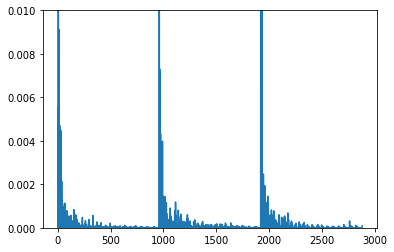

In [75]:
plt.plot(np.abs(Amin.x) - np.abs(Ainit))
plt.ylim(0,0.01)
plt.show()
#np.save()

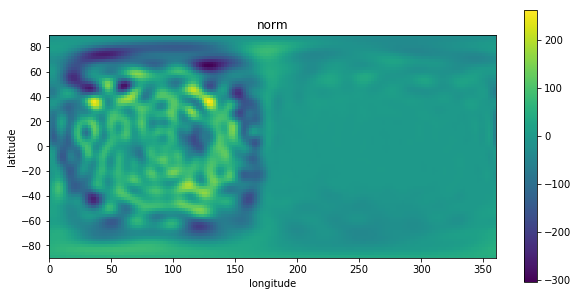

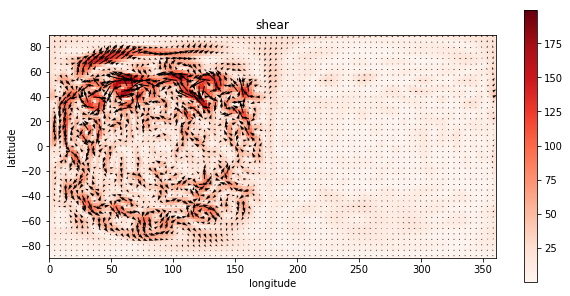

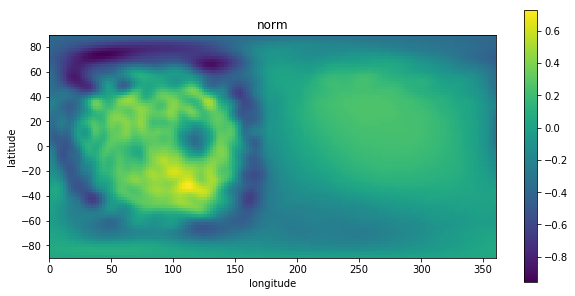

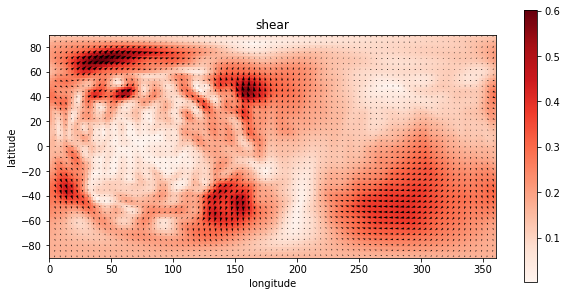

fitting after minimization: 0.05304001 microns, 4.3205 Pa, 0.0000 Pa; eval time: 0.0190s
point-trimesh distance: 0.03361221 microns


In [77]:
fileformat = '.png'
#np.save(Ainitfile, Amin)

#aKmin = Amindamp
aKmin = Amin.x #Amin.x[:-3];# u0 = Amin.x[-3:];
Tvecmin = Cmat.dot(aKmin)
Uvecmin = Dmat.dot(aKmin)
fig, ax = visSHVec(Tvecmin*mu0, lmax_plot=lmax_plot, lonshift=180, Complex=True, config_quiver=(2,int(lmax_plot/lJmax),'k', 4000), show=False)
fig[0].savefig(Aminfile+'_Tn'+fileformat, transparent=True)
fig[1].savefig(Aminfile+'_Ts'+fileformat, transparent=True)
fig, ax = visSHVec(Uvecmin*r0, lmax_plot=lmax_plot, lonshift=180, Complex=True, config_quiver=(2,int(lmax_plot/lJmax),'k', 40))
fig[0].savefig(Aminfile+'_un'+fileformat, transparent=True)
fig[1].savefig(Aminfile+'_us'+fileformat, transparent=True)

tic = time.time()
Asol = sol2dist(Amin.x, Cmat, Dmat, alpha=alpha, separate=True, noshear=1)
toc = time.time()
print('fitting after minimization: %.8f microns, %.4f Pa, %.4f Pa; eval time: %.4fs'% 
     (Asol[0]*r0, Asol[1]*mu0, Asol[2]*mu0, toc-tic))
f_cached = generate_fcache(Fneigh)
print('point-trimesh distance: %.8f microns'%
      (coeffs2dist(Uvecmin, Fneigh, f_cached=f_cached,
                   lmax=lJmax, Complex=True, X0=X0,
                   lat_weights=lat_weights[:,np.newaxis], vert_weight=vert_weight)*r0))

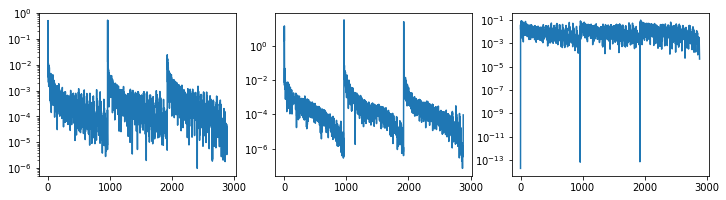

In [78]:
plt.figure(figsize=(12,3))
plt.subplot(131); plt.semilogy(np.abs(Uvecmin)); #plt.ylim(0, 0.01)
plt.subplot(132); plt.semilogy(np.abs(Amin.x)); #plt.ylim(0, 0.01)
plt.subplot(133); plt.semilogy(np.abs(Tvecmin)); #plt.ylim(0, 0.01)
plt.show()

(81, 161, 3)


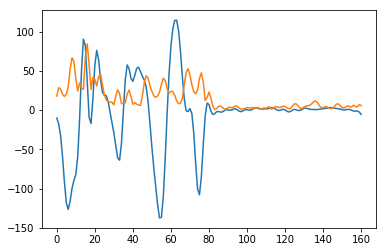

In [79]:
tsph = SHVec2mesh(Tvecmin*mu0, lmax=lmax_plot, Complex=True, SphCoord=True)
print(tsph.shape)
tsmag = np.mean(np.linalg.norm(tsph[40:43, :, 1:], axis=-1), axis=0)
plt.plot(np.roll(tsph[40:43, :, 0].mean(axis=0), 81))
plt.plot(np.roll(tsmag, 81))
plt.show()

Then we will visualize the shape in 3D:

In [80]:
umesh = SHVec2mesh(Uvecmin, lmax=lJmax, SphCoord=False, Complex=True)
tmesh = SHVec2mesh(Tvecmin*mu0, lmax=lJmax, Complex=True, SphCoord=False)
Xt = X0 + umesh

umesh_fine = SHVec2mesh(Uvecmin, lmax=lmax_plot, SphCoord=False, Complex=True)
tmesh_fine = SHVec2mesh(Tvecmin*mu0, lmax=lmax_plot, Complex=True, SphCoord=False)

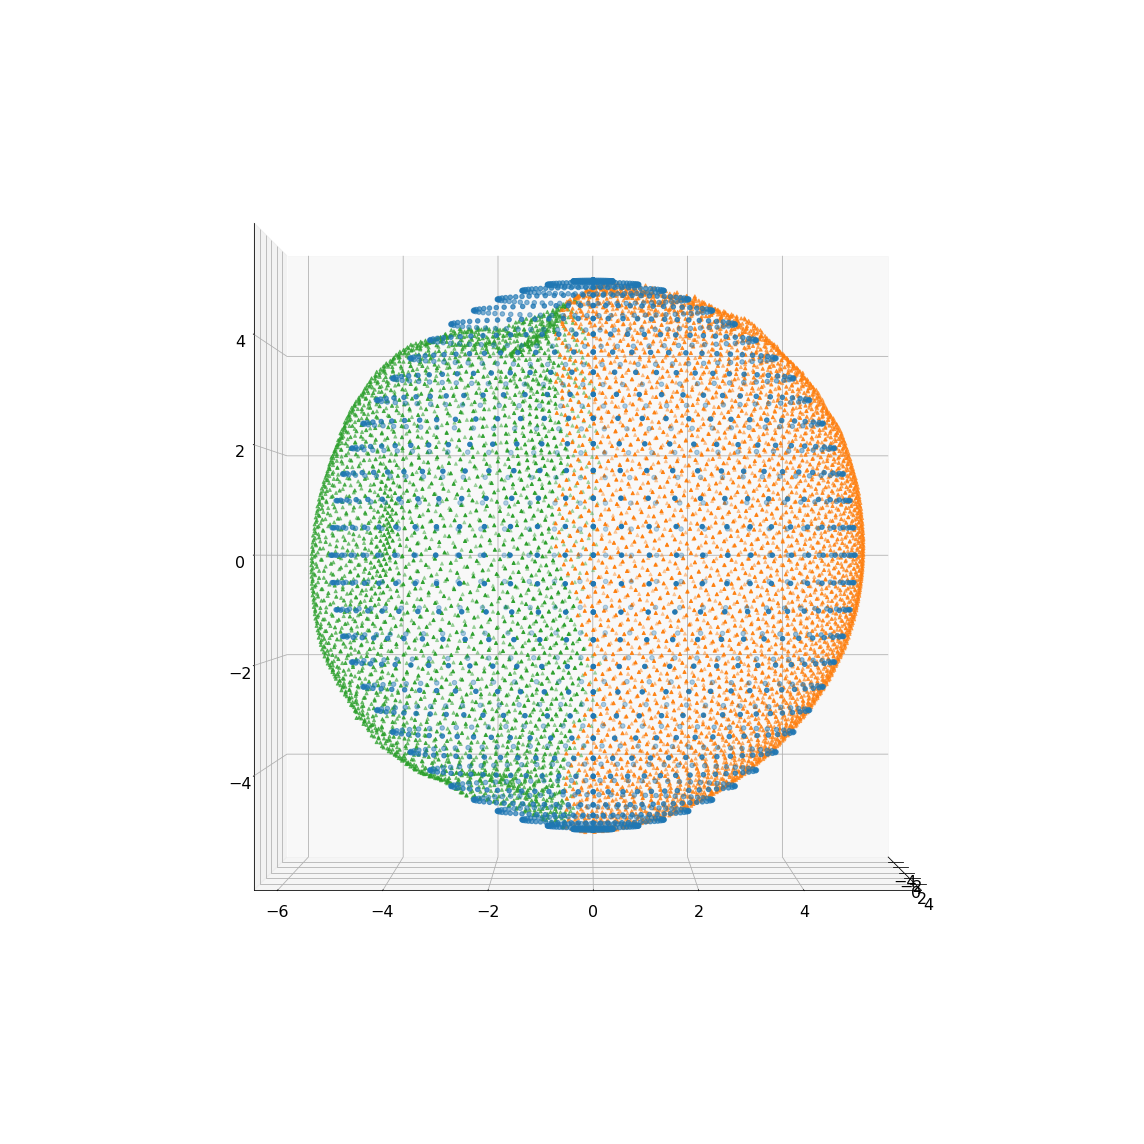

In [81]:
fig, ax = visSH3d(umesh*0, cmesh=tmesh, r0=r0, show=False, elevation=0)
nTfv = np.logical_not(Tfv)
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)
plt.tight_layout()
fig.savefig(Aminfile+'_3dshape_original.png', transparent=True)
plt.show()

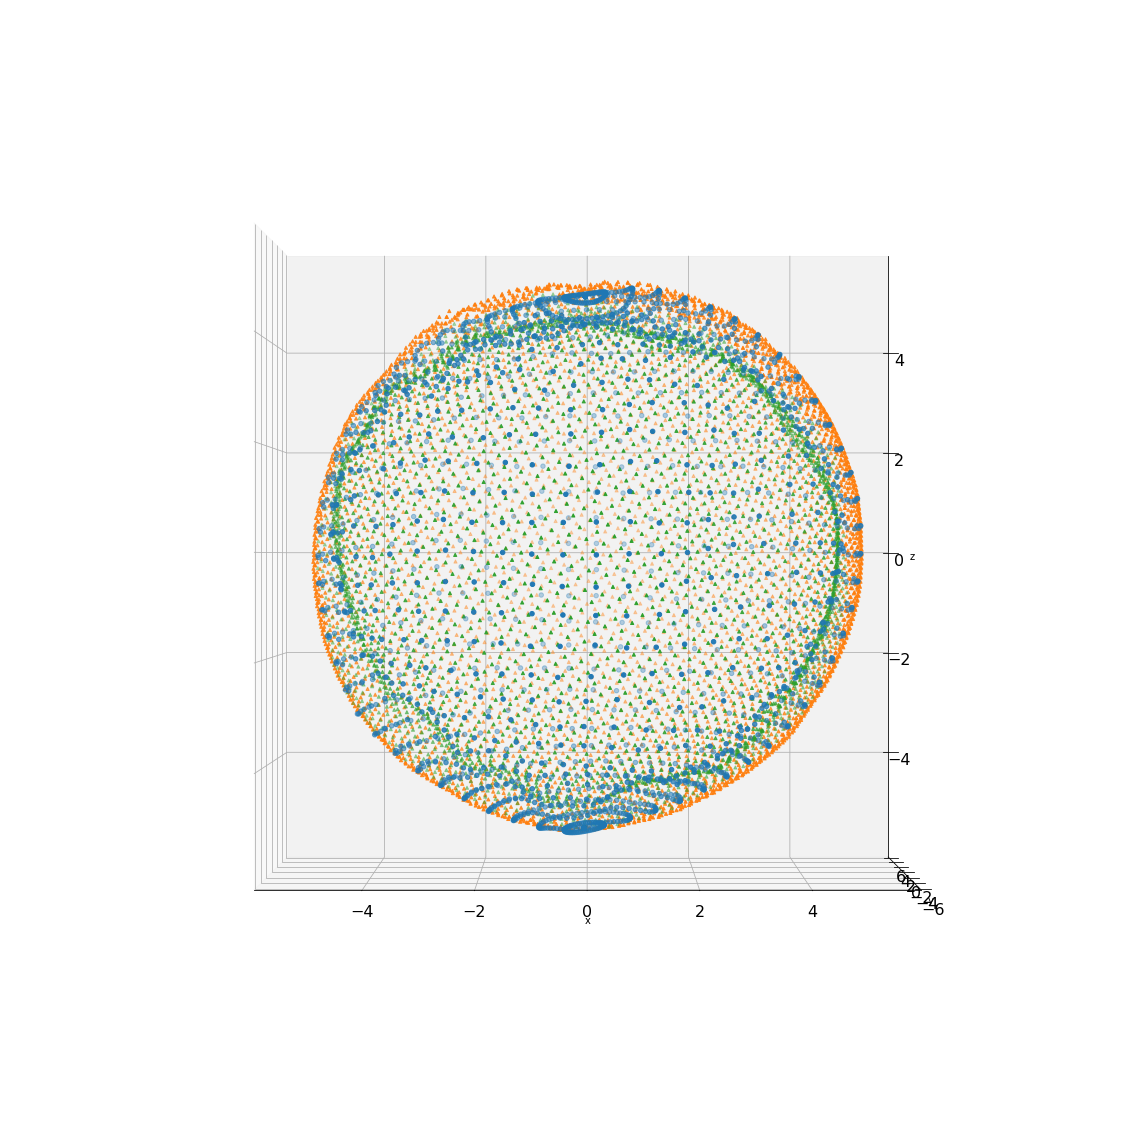

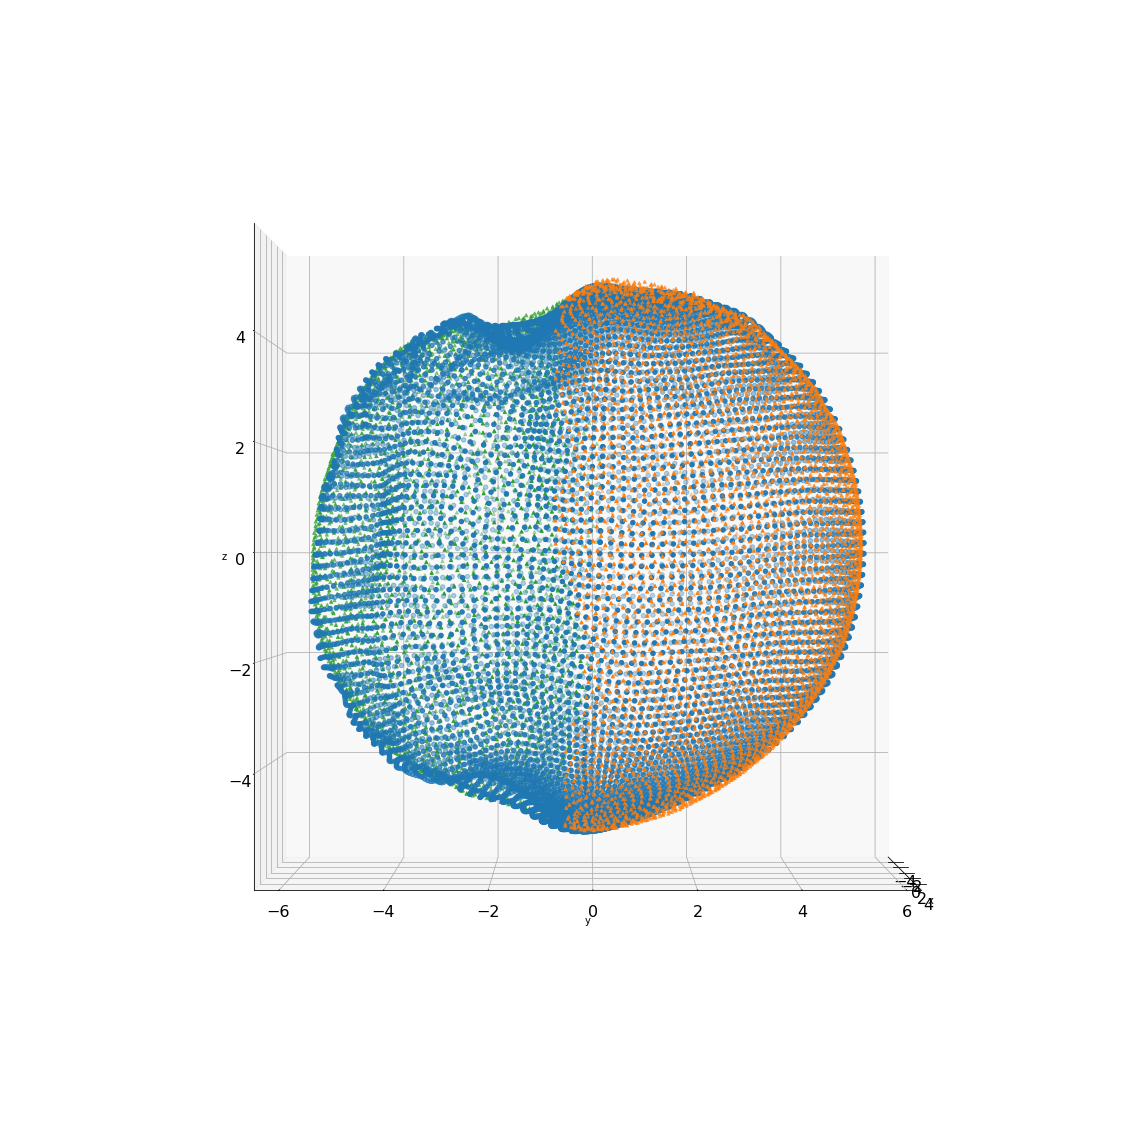

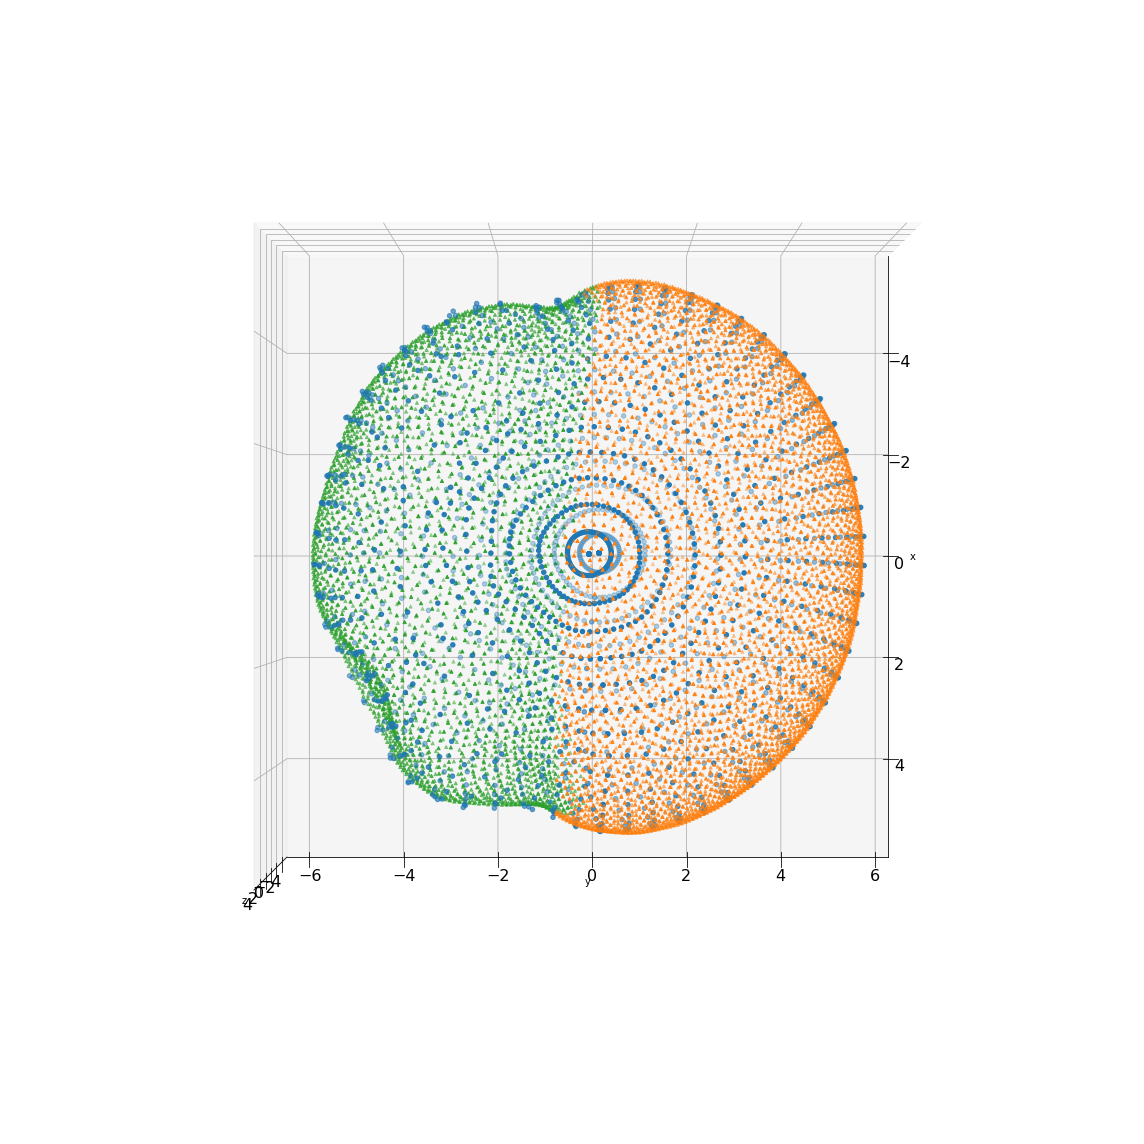

In [82]:
fig, ax = visSH3d(umesh, cmesh=tmesh, r0=r0, show=False, elevation=0, azimuth=-90)
nTfv = np.logical_not(Tfv)
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
plt.tight_layout()
fig.savefig(Aminfile+'_3dshape_left.png', transparent=True)
plt.show()
fig, ax = visSH3d(umesh_fine, cmesh=tmesh_fine, r0=r0, show=False, elevation=0, azimuth=0)
#fig, ax = visSH3d(umesh_fine, cmesh=tmesh_fine, r0=r0, show=False, elevation=0, azimuth=0, surface=True)
nTfv = np.logical_not(Tfv)
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
plt.tight_layout()
fig.savefig(Aminfile+'_3dshape_front.png', transparent=True)
plt.show()
fig, ax = visSH3d(umesh, cmesh=tmesh, r0=r0, show=False, elevation=90, azimuth=0)
nTfv = np.logical_not(Tfv)
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
plt.tight_layout()
fig.savefig(Aminfile+'_3dshape_top.png', transparent=True)
plt.show()

Visualize the neighbor list on deformed shape:

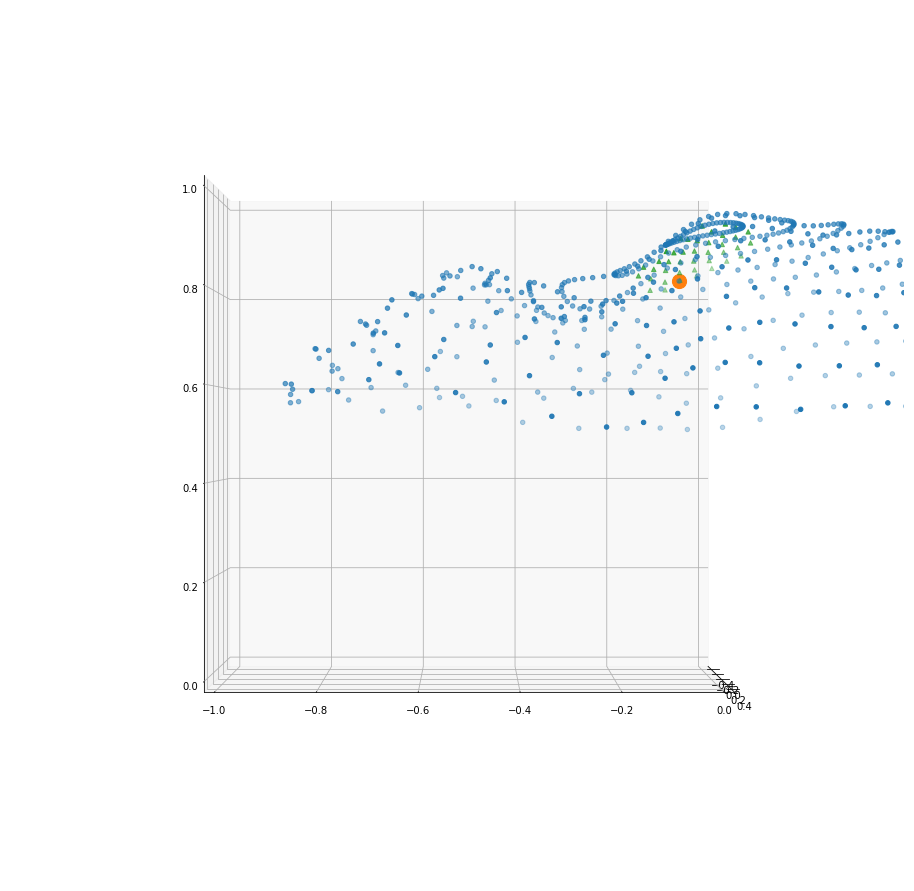

In [83]:
i = 3; j = 31;
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(Xt[0:10,:, 0], Xt[0:10,:, 1], Xt[0:10,:, 2])
#ax.scatter3D(Xt[:, :, 0], Xt[:, :, 1], Xt[:, :, 2], s=1)
ax.scatter3D(Xt[i, j, 0], Xt[i, j, 1], Xt[i, j, 2], s=200)
ax.scatter3D(Xneigh[i, j, :, 0], Xneigh[i, j, :, 1], Xneigh[i, j, :, 2], marker = '^')
#nTfv = np.logical_not(Tfv)
#ax.scatter3D(Vp[Tfv, 0]/r0, Vp[Tfv, 1]/r0, Vp[Tfv, 2]/r0, s = 1)#, c='C0')
#ax.scatter3D(Vp[nTfv, 0]/r0, Vp[nTfv, 1]/r0, Vp[nTfv, 2]/r0, s = 1)#, c='C1')
ax.view_init(azim=0, elev=0)
ax.set_zlim3d(0, 1); ax.set_xlim3d(-0.5, 0.5); ax.set_ylim3d(-1, 0)
#ax.set_aspect('equal')

plt.show()